# 心脏病预测

## 背景介绍：
世界卫生组织估计，全球每年有1200万人死于心脏病。美国和其他发达国家一半的死亡是由于心血管疾病。心血管疾病的早期预后可以帮助高危患者决定改变生活方式，从而减少并发症。本项目旨在首先通过探索性数据分析，探索各预测变量与心脏发病的关系，其次建立KNN,logistics回归、xgboost三类模型根据样本身体指标预测是否患心脏病，项目将以患病类型召回率为主，F1,ROC等多种指标作为模型评价标准，项目将对每个模型进行超参数调优，并比较不同模型在数据集的表现，并尝试分析原因。
## 数据来源与说明：
数据集获取网址：“https://archive.ics.uci.edu/dataset/45/heart+disease“
共303个样本，13个特征，特征说明见下。

## 1. 导包

In [149]:
 import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox,uniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV,train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,precision_score, recall_score,roc_curve, auc,accuracy_score,f1_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
%matplotlib inline

In [150]:
# Set the resolution of the plotted figures
plt.rcParams['figure.dpi'] = 200

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#f0f0f0'}, style='darkgrid')


In [151]:
import sys
print(sys.version)

3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:06:23) [MSC v.1942 64 bit (AMD64)]


In [152]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import scipy 
import sklearn
import xgboost as xgb
import statsmodels

# 查看包的版本
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("scipy version:", scipy.__version__)  
print("sklearn version:", sklearn.__version__)  
print("xgboost version:", xgb.__version__)
print("statsmodels version:",statsmodels.__version__)

numpy version: 1.26.4
pandas version: 1.5.3
matplotlib version: 3.10.0
seaborn version: 0.12.2
scipy version: 1.14.1
sklearn version: 1.3.2
xgboost version: 2.1.3
statsmodels version: 0.14.4


## 2. 导入数据

In [153]:
try:
    df = pd.read_csv('heart.csv')
except FileNotFoundError:
    print("CSV文件未找到。")
except pd.errors.EmptyDataError:
    print("CSV文件为空。")
except pd.errors.ParserError:
    print("解析CSV文件时出错。")
except Exception as e:
    print(f"读取CSV文件时发生错误：{e}")

In [154]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1




<h3 align="left"><font color=black>Dataset Description:</font></h3>

    
| __Variable__ | __Description__ |
|     :---      |       :---      |      
| __age__ | Age of the patient in years |
| __sex__ | Gender of the patient (0 = male, 1 = female) |
| __cp__ | Chest pain type: <br> 0: Typical angina <br> 1: Atypical angina <br> 2: Non-anginal pain <br> 3: Asymptomatic |
| __trestbps__ | Resting blood pressure in mm Hg |
| __chol__ | Serum cholesterol in mg/dl |                     
| __fbs__ | Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false) |
| __restecg__ | Resting electrocardiographic results: <br> 0: Normal <br> 1: Having ST-T wave abnormality <br> 2: Showing probable or definite left ventricular hypertrophy |  
| __thalach__ | Maximum heart rate achieved during a stress test |                      
| __exang__ | Exercise-induced angina (1 = yes, 0 = no) |
| __oldpeak__ | ST depression induced by exercise relative to rest |
| __slope__ | Slope of the peak exercise ST segment: <br> 0: Upsloping <br> 1: Flat <br> 2: Downsloping |                      
| __ca__ | Number of major vessels (0-4) colored by fluoroscopy |              
| __thal__ | Thalium stress test result: <br> 0: Normal <br> 1: Fixed defect <br> 2: Reversible defect <br> 3: Not described  |
| __target__ | Heart disease status (0 = no disease, 1 = presence of disease) |

## 3. 数据概览

### 3.1 数据基本信息

In [155]:
# Display a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### 分析如下：
1. 数据集有303个样本，13个特征，除oldpeak为float64型外，其余特征均为int64型，
2. 数据无null值
3. 连续型特征：

#### __分析如下__ ：
* __样本量__: 数据集有 __303__ 个样本
    
    
* __特征__: 数据集共 __14__ 列，其中包括描述病人属性的 __13__ 个特征和 __1__ 个结果 .
    
    
* __数据类型__:仅oldpeak列为 __float64__ 型，其余列均为 __int64__ 型 
    
* __缺失值__: 无缺失值，303个样本均为 __non-null__ .

**注意**：根据我们之前的数据类型和特征解释，我们可以看到9列（sex、cp、fbs、restecg、exang、slope、ca、thal和target）在数据类型方面确实是数字的，但在语义方面是分类的。这些特征应转换为字符串（对象）数据类型，以便进行适当的分析和解释。

**修改列名为中文**

In [156]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [157]:
df.columns = ['年龄','性别','胸痛类型','静息血压','血清胆固醇','空腹血糖','静息心电图结果'
              ,'最大心率','运动诱导型心绞痛','运动引起的ST段压低','峰值运动ST段的斜率','主要血管数量','铊压力测试结果','是否得病']

In [158]:
df.columns

Index(['年龄', '性别', '胸痛类型', '静息血压', '血清胆固醇', '空腹血糖', '静息心电图结果', '最大心率',
       '运动诱导型心绞痛', '运动引起的ST段压低', '峰值运动ST段的斜率', '主要血管数量', '铊压力测试结果', '是否得病'],
      dtype='object')

In [159]:
# Define the continuous features
continuous_features = ['年龄', '静息血压', '血清胆固醇', '最大心率', '运动引起的ST段压低']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

年龄              int64
性别             object
胸痛类型           object
静息血压            int64
血清胆固醇           int64
空腹血糖           object
静息心电图结果        object
最大心率            int64
运动诱导型心绞痛       object
运动引起的ST段压低    float64
峰值运动ST段的斜率     object
主要血管数量         object
铊压力测试结果        object
是否得病           object
dtype: object

### 3.2 数值型变量的统计信息

In [160]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
年龄,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
静息血压,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
血清胆固醇,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
最大心率,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
运动引起的ST段压低,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


#### **数字特征**：

* 年龄（age）：平均年龄约为55岁，范围在29至77岁之间，标准差约为9。
* 静息血压（trestbps）：平均静息血压约为131毫米汞柱，范围在94至200毫米汞柱之间，标准差约为18。
* 血清胆固醇（chol）：平均胆固醇水平约为240 mg/dl，范围在126至564 mg/dl之间，标准差约为52。
* 压力测试最大心率（thalach）：达到的平均最大心率约为153，范围在71到202之间，标准差约为23。
* 运动相对于休息引起的ST段压低（oldpeak）：相对于休息，运动引起的平均ST段压低约为0.8，范围在0到6.2之间，标准差约为1。

### 3.3 分类型变量的统计信息

In [161]:
# Get the summary statistics for categorical variables
df.describe(include='object')

,性别,胸痛类型,空腹血糖,静息心电图结果,运动诱导型心绞痛,峰值运动ST段的斜率,主要血管数量,铊压力测试结果,是否得病
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


是最常见的，在165个条目中观察到。

#### **分类特征（对象数据类型）**：

**性别**：有两个独特的值，其中男性（表示为0）是最常见的类别，在303个条目中出现了207次

**胸痛类型**：存在四种独特的胸痛类型。最常见的类型是“0”，出现143次。

**空腹血糖水平**：有两类，最常见的是“0”（表示空腹血糖低于120mg/dl），出现258次。

**静息心电图结果**：目前有三个独特的结果。最常见的结果是“1”，出现152次。

**运动型心绞痛**：有两个独特的值。最常见的值是“0”（表示没有运动性心绞痛），观察204次。

**峰值运动ST段斜率**：有三个独特的斜坡。最常见的斜坡类型是“2”，出现142次。

**荧光透视染色的主要血管数量**：荧光透视染色的主要血管数量有五个独特的值，其中“0”是最常见的，出现175次。

**铊应力测试结果**：有四个独特的结果。最常见的类型是“2”（表示可逆缺陷），观察了166次。

**目标**：两个独特的值表示是否存在心脏病。值“1”（表示存在心脏病）是最常见的，在165个条目中观察到。

## 4.探索性数据分析（EDA）

对于我们的探索性数据分析（EDA），我们将分两个主要步骤进行：

>1.__单变量分析__ ：在这里，我们将一次关注一个特征，以了解其分布和范围。

>2.__双变量分析__ ：在这一步中，我们将探索每个特征与目标变量之间的关系。这有助于我们了解每个特征对目标结果的重要性和影响。

通过这两个步骤，我们的目标是深入了解数据的个体特征，以及每个特征与我们的主要目标的关系：预测目标变量。

In [162]:
# matplotlib显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

### 目标变量

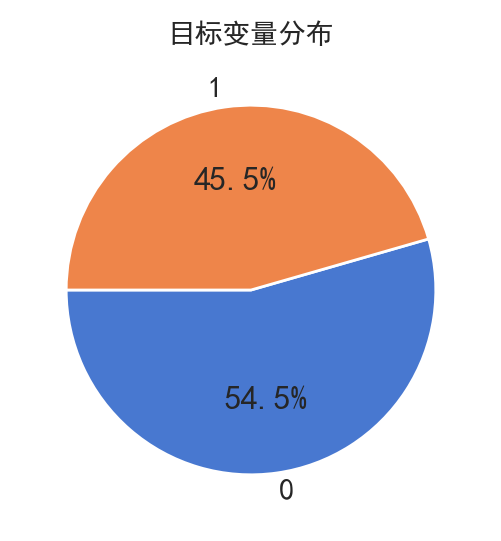

In [163]:
# Define the Response categories and count occurrences
categories = [0, 1]
counts = df.是否得病.value_counts().tolist()

# Choose a color palette from Seaborn for the pie chart
colors = sns.color_palette("muted")

# Plot the pie chart with the counts of each response category
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=180, colors=colors)
plt.title('目标变量分布',fontsize=10)
plt.show()

目标变量是二分类数据，且比例较为平衡。

### 4.1 单变量分析

我们根据数据类型对数据集的特征进行单变量分析：

* 对于 __连续数据__ ：
  * 使用直方图来深入了解每个特征的分布。这使我们能够了解数据集分布的中心趋势、分布和形状。
  * 使用箱型图检测异常值。
  * 使用热图反映变量之间的相关性。
* 对于 __分类数据__ ：使用条形图来可视化每个类别的频率。这清楚地表明了每个类别在各自特征中的突出程度。

通过采用这些可视化技术，我们可以更好地理解数据集中每个特征的个体特征。

#### 4.1.1 单变量分析——数值型

1. 分布特征

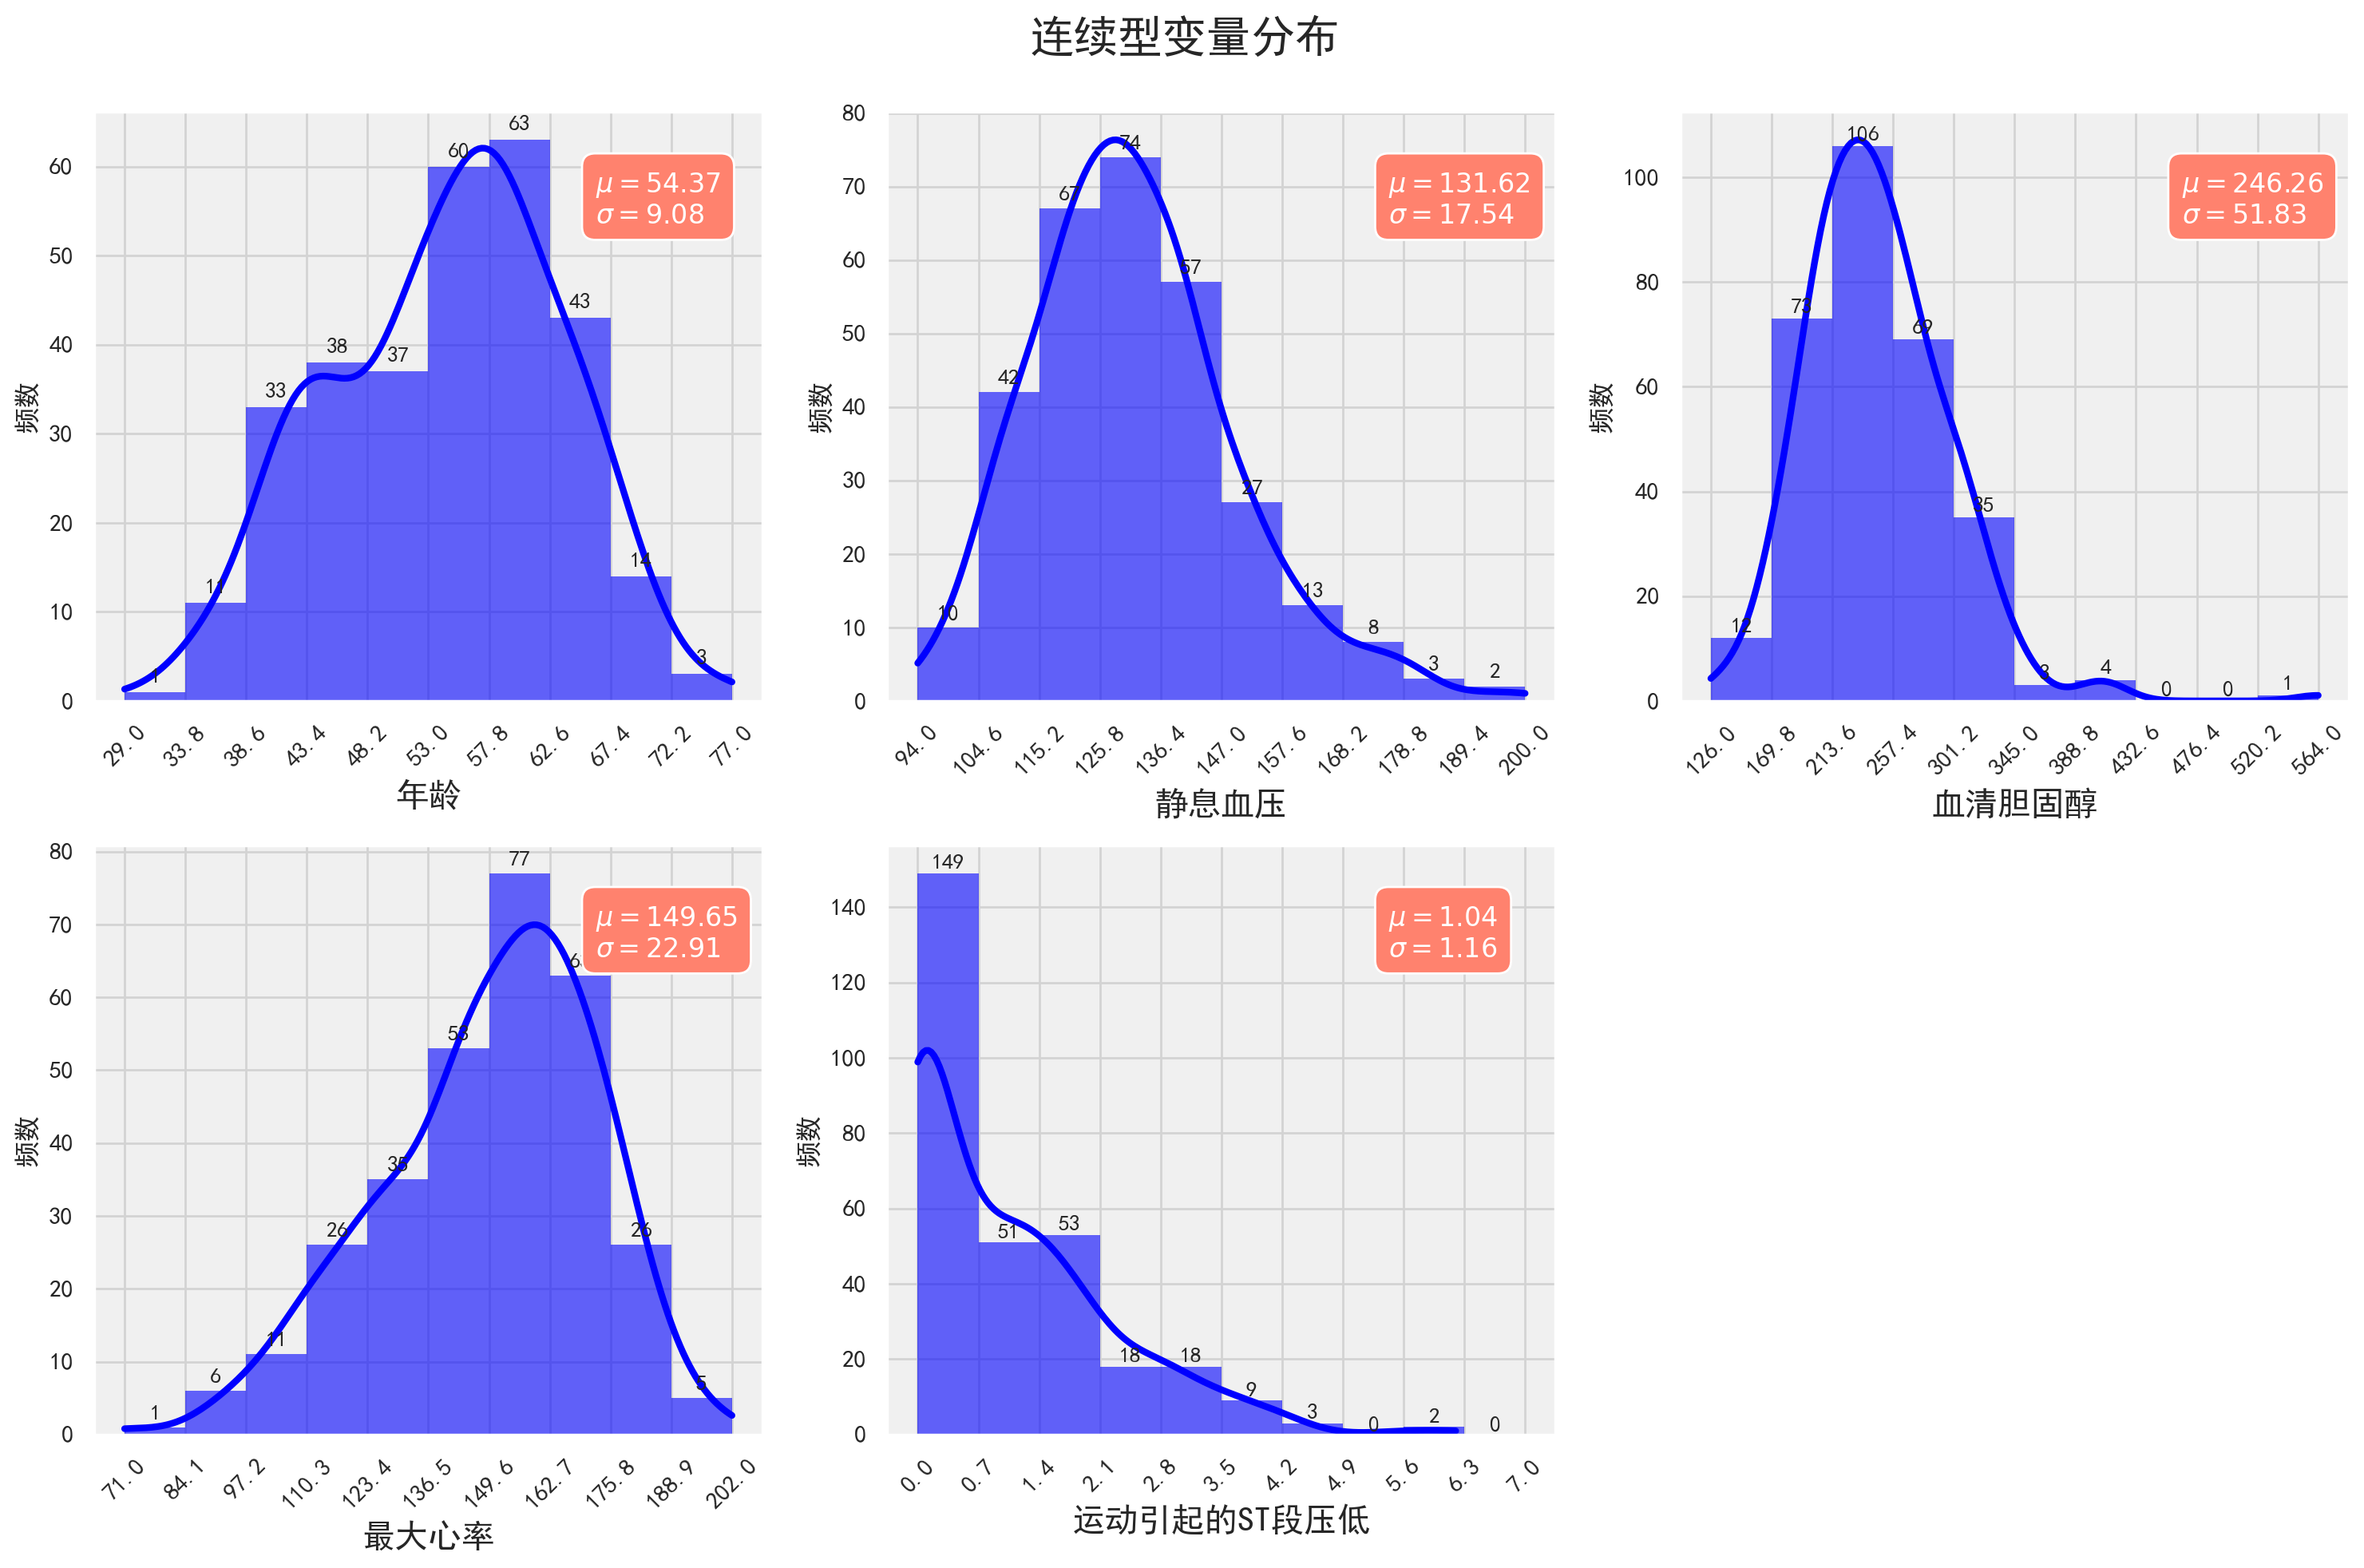

In [164]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='blue', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('频数', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    #添加柱形图上的数字
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")

    #添加均值和标准差
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std() 
                        ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))
    
ax[1,2].axis('off') #不画最后一个子图
plt.suptitle('连续型变量分布', fontsize=20)
plt.tight_layout()#tight_layout方法自动调整子图参数，以便子图之间有足够的空间，并且子图的内容不会重叠。这对于避免标签、标题或轴与子图内容相互重叠非常有用。
plt.subplots_adjust(top=0.92)#subplots_adjust方法用于手动调整子图之间的间距。这里的top=0.92参数指定了子图上方的空间占整个图形高度的比例。调整这个值可以为图表的标题或其他元素腾出空间。
plt.show()

#### **推论**：

* 年龄（Age）：分布较为对称，但在38和60岁左右有两个峰值。
* 静息血压（trestbps）：分布尾部略右偏，大多数人的静息血压集中在115-140 mm Hg左右。
* 血清胆固醇（chol）：分布尾部右偏，大多数人的胆固醇水平在170至300mg/dl之间。。
* 最大心率（thalach）：分布尾部左偏，在压力测试中，大多数人最大心率在135到175 bpm之间。
* 运动引起的ST段压低（oldpeak）：分布尾部明显右偏，大多数值集中在0附近，表明许多人在运动期间没有出现明显的ST段降低。
  
    综上，静息血压（trestbps）、血清胆固醇（chol）尾部轻微右偏，最大心率（thalach）尾部左偏，运动引起的ST段压低（oldpeak）尾部明显右偏，在数据预处理时可以通过Box-Cox变化以减少数据不对称的影响。此外，对于偏度不为0的数据，可以进一步通过箱型图观测数据是否具有异常值

2. 检测异常值：

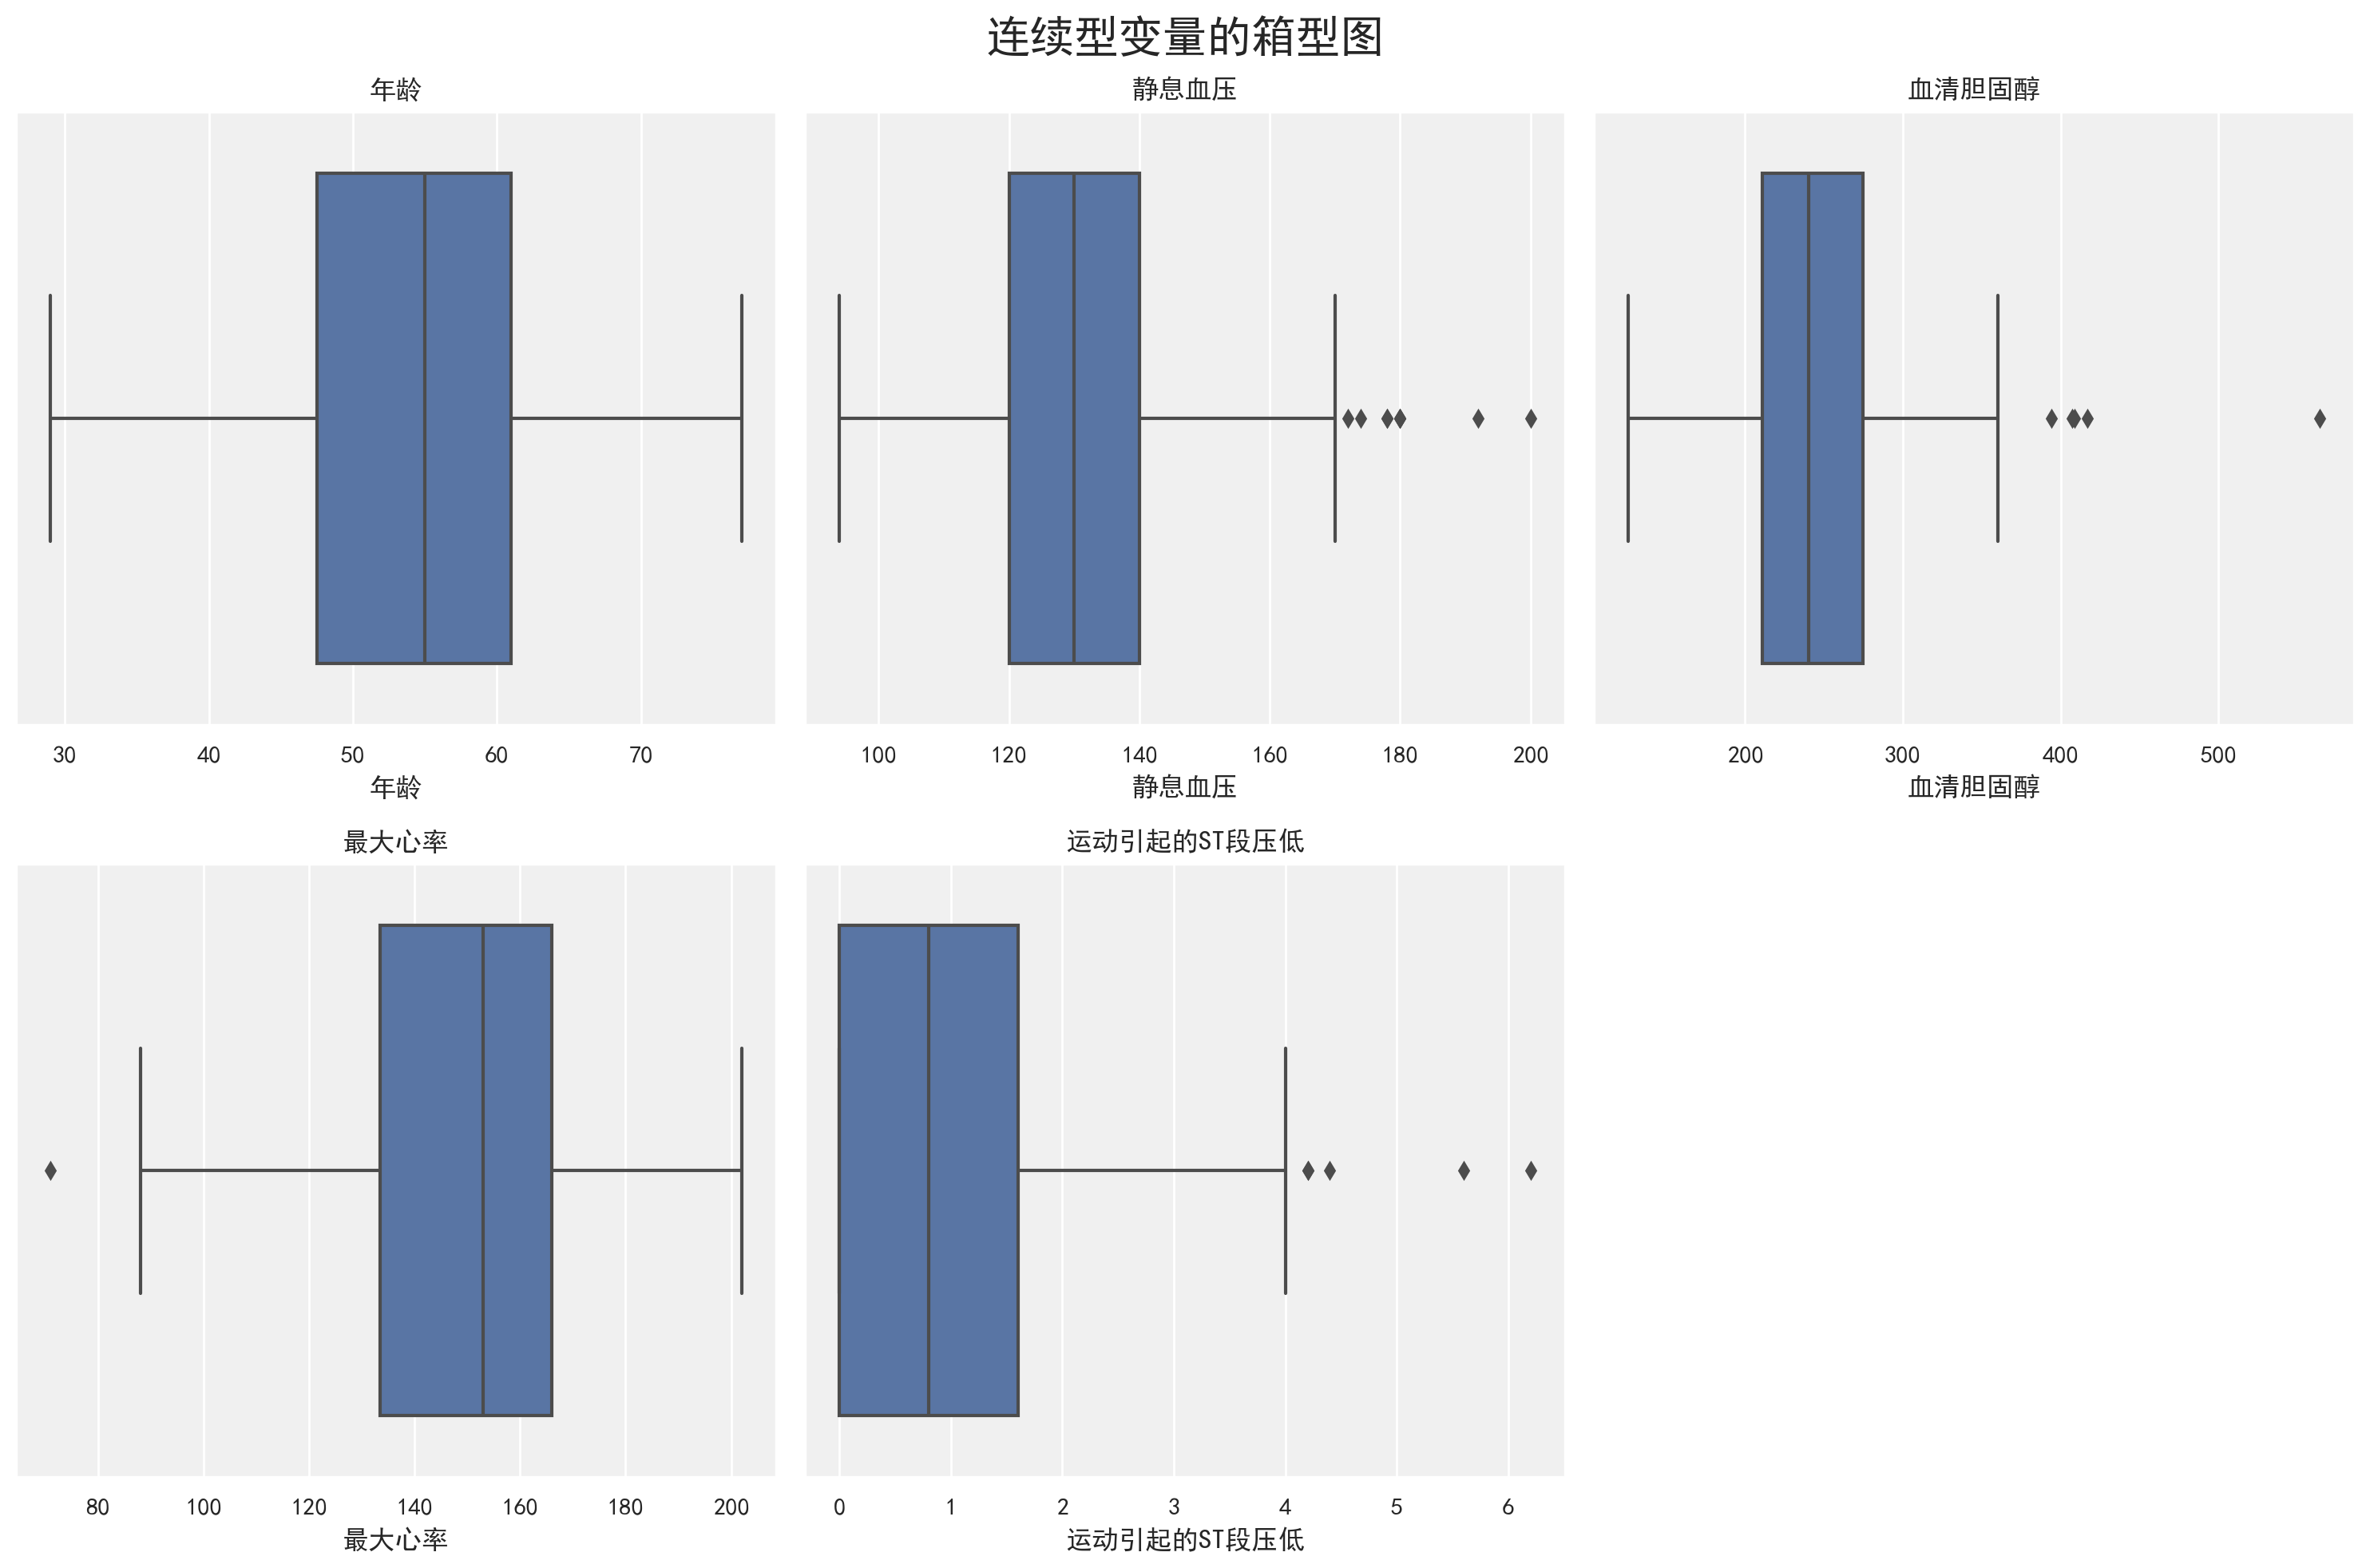

In [165]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    sns.boxplot(ax=ax[x,y], x=df_continuous[col])
    ax[x,y].set_title(col)

ax[1,2].axis('off') #不画最后一个子图
plt.suptitle('连续型变量的箱型图', fontsize=20)
plt.tight_layout()#tight_layout方法自动调整子图参数，以便子图之间有足够的空间，并且子图的内容不会重叠。这对于避免标签、标题或轴与子图内容相互重叠非常有用。
plt.subplots_adjust(top=0.92)#subplots_adjust方法用于手动调整子图之间的间距。这里的top=0.92参数指定了子图上方的空间占整个图形高度的比例。调整这个值可以为图表的标题或其他元素腾出空间。
plt.show()

#### **推论**：

* 年龄（Age）：无异常值

* 静息血压（trestbps）：有少数异常值，部分样本静息血压异常高。

* 血清胆固醇（chol）：有少数异常值，部分样本血清胆固醇异常高。

* 最大心率（thalach）：有一个异常值点，该样本最大心率异常低。

* 运动引起的ST段压低（oldpeak）：有少数异常值，部分样本运动引起的ST段压低异常高。

部分特征具有异常值，在建模前可以通过对异常值稳定的方法对数据进行标准化或者选择对异常值稳健的方法。

3.变量之间的相关性分析：

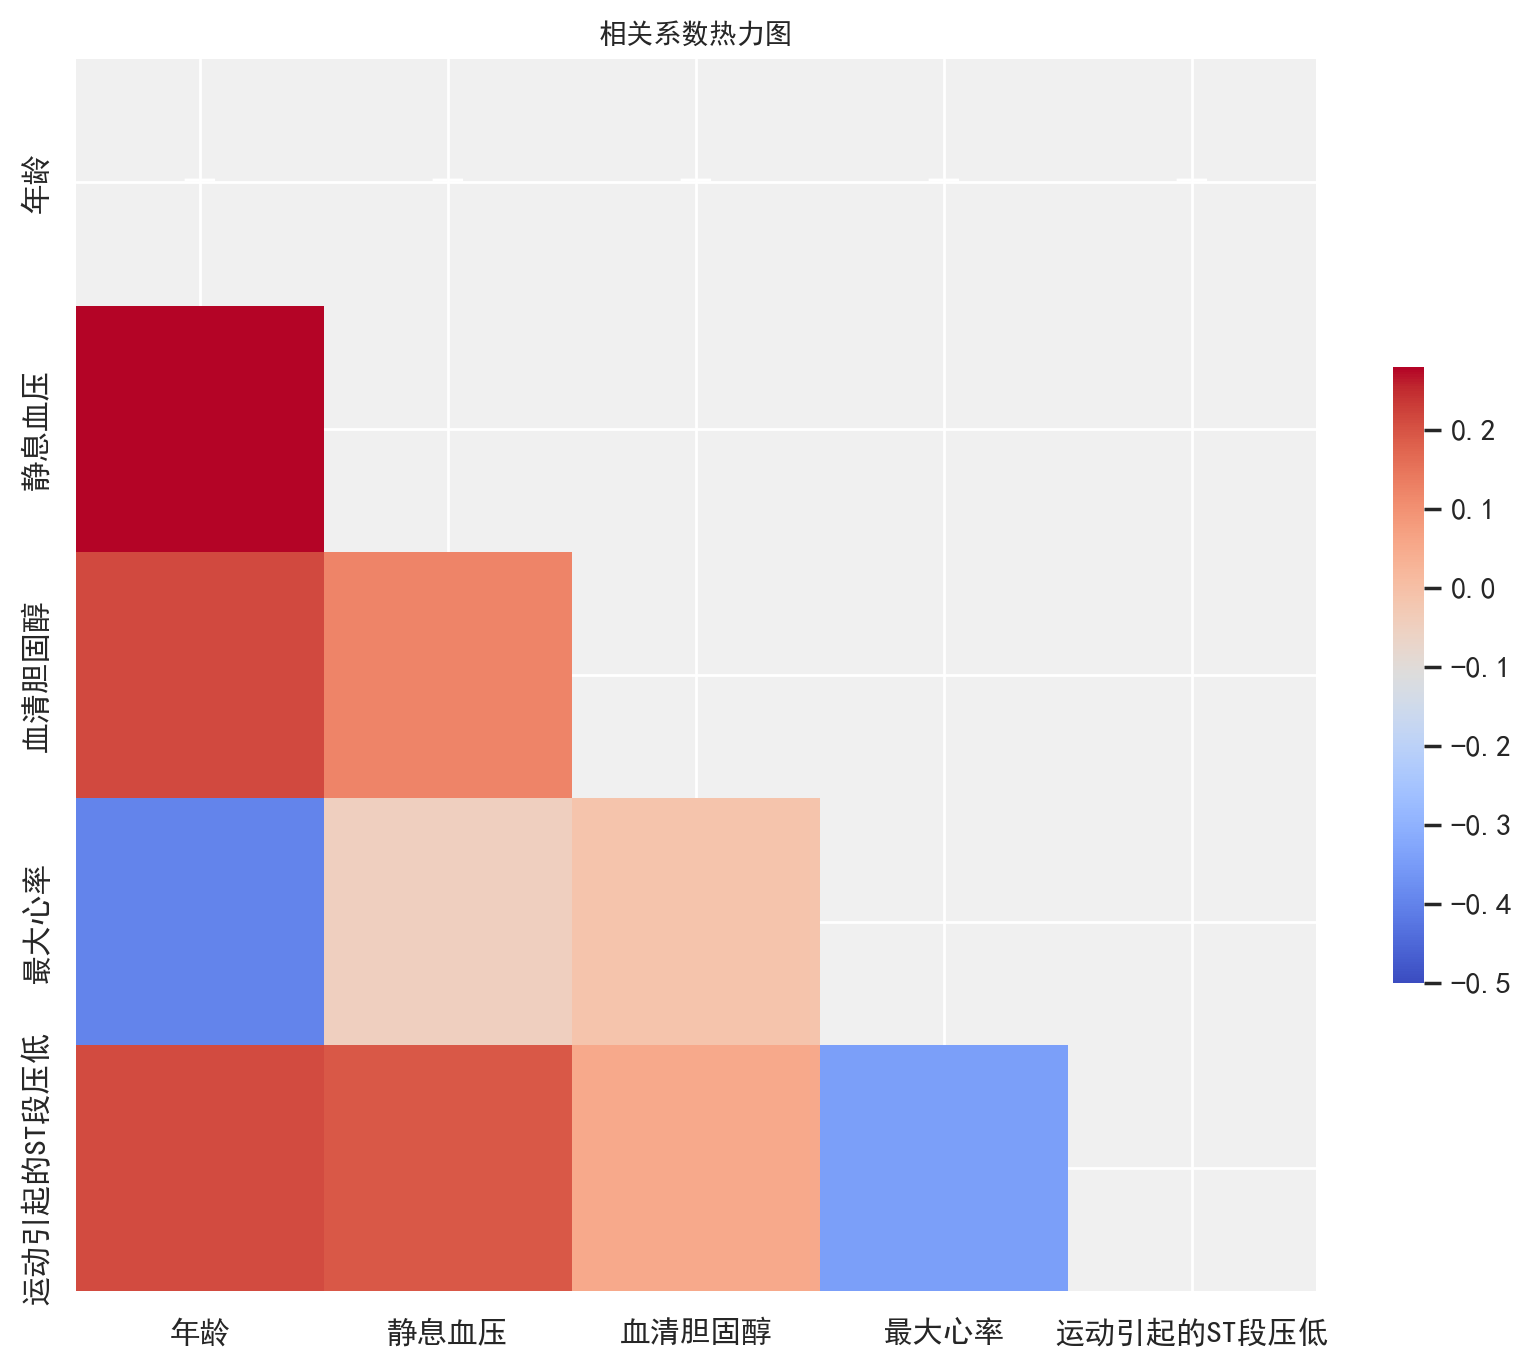

In [166]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(df_continuous.corr(), dtype=bool))

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_continuous.corr(),cmap='coolwarm', cbar_kws={"shrink": .5}, vmin=-0.5, mask=mask, annot=True, fmt=".2f")

# Add a title to the heatmap
plt.title('相关系数热力图', fontsize=10)

plt.show()

#### **推论**：
* 年龄（age）与最大心率（thalach）相关系数为-0.4，有较为明显的负相关关系， 说明随着年龄增大，压力测试后的最大心率有降低的趋势。
* 年龄（age）与静息血压（thalach）相关系数为0.28，有一定的正相关关系，说明随着年龄增大，静息血压有增大的趋势，这符合老年人相对容易高血压的认知。
* 3	运动引起的ST段压低（oldpeak）与最大心率（thalach）相关系数为-0.34，有一定的负相关关系。


#### 4.1.2 单变量分析——分类型数据：

In [167]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != '是否得病']
df_categorical = df[categorical_features]

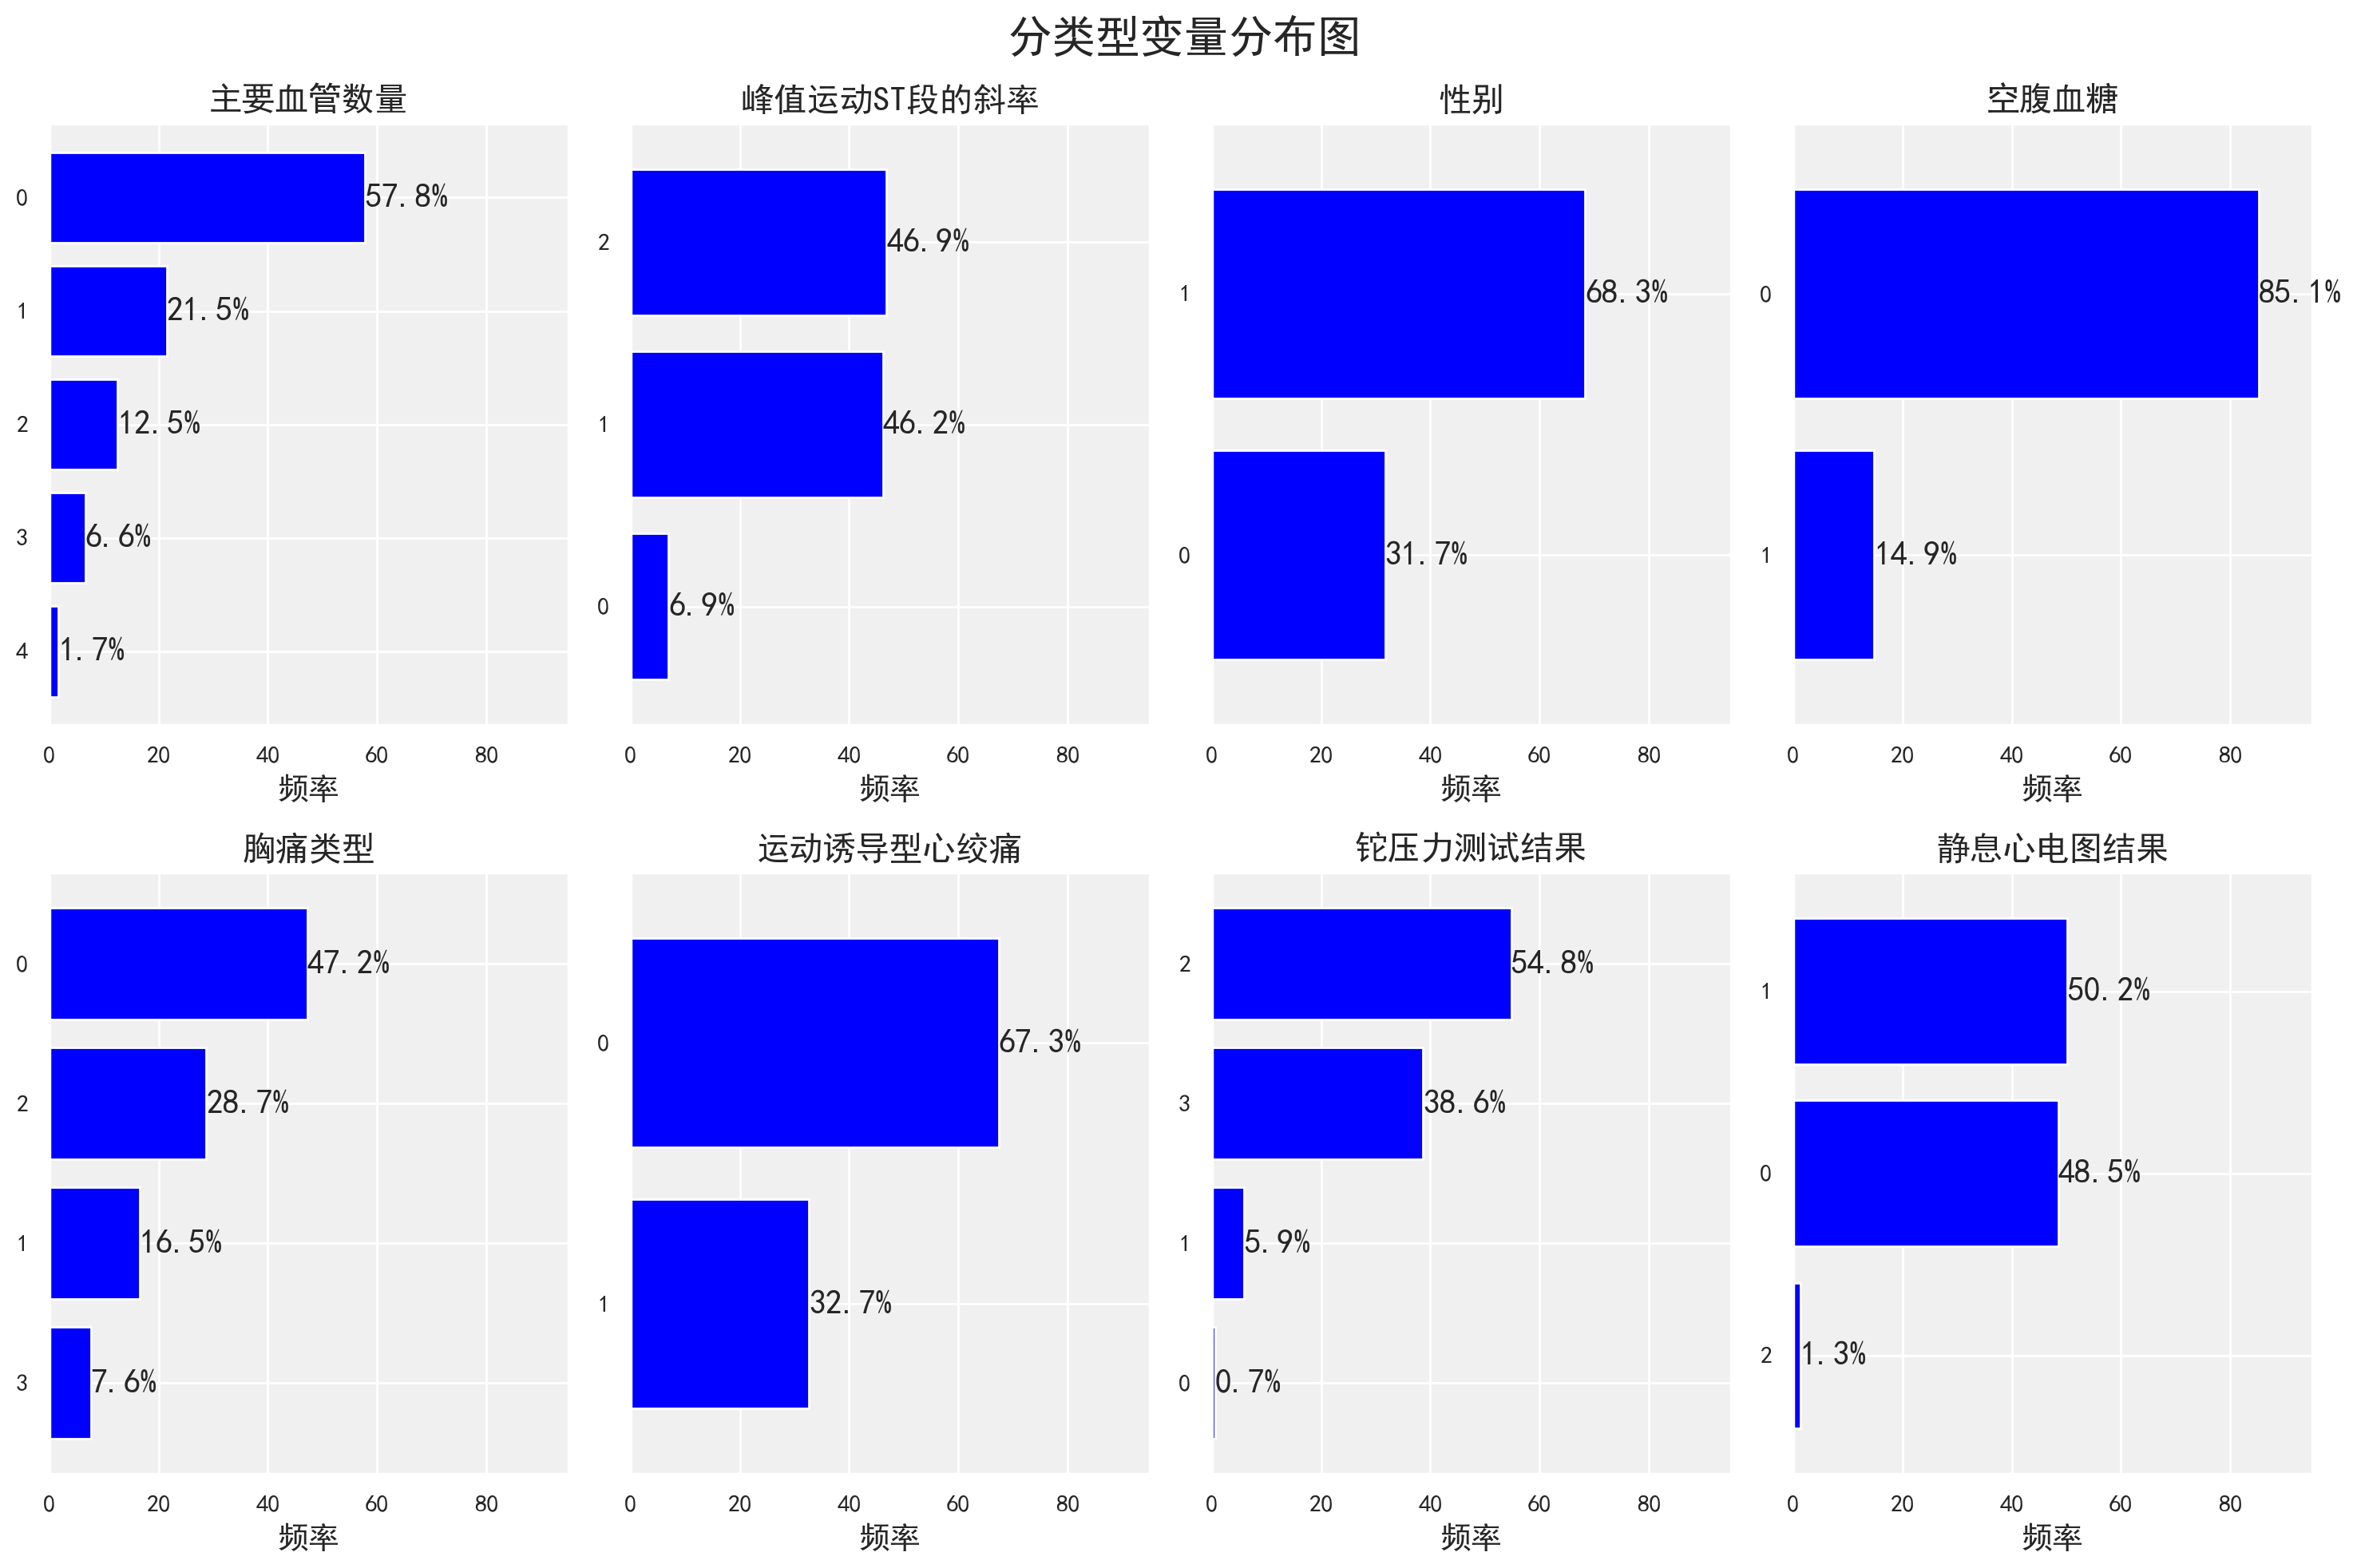

In [168]:
# Set up the subplot for a 4x2 layout
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    # row = i // 2
    # col_idx = i % 2
    row, col_idx = i//4, i%4
    
    # Calculate frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='blue')
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('频率', fontsize=14)
    ax[row, col_idx].set_title(f'{col}', fontsize=15)


plt.suptitle('分类型变量分布图', fontsize=20)
plt.tight_layout()
# plt.subplots_adjust(top=0.95)
plt.show()

#### **推论**：
* 荧光镜检查着色的主要血管数量（ca）：样本能看到的着色主要血管数量范围为0~4条，其中大多数样本荧光镜检查的主要血管较少,约57.8%的样本荧光镜检查无血管。

* 胸痛类型（cp）：共4钟胸痛类型，其中0型（典型心绞痛）是最常见的，占比约47.2%。

* 运动诱导型心绞痛（exang）：约67.3%的样本没有运动诱导性心绞痛。

* 空腹血糖（fbs）：约85.1%的样本空腹血糖水平低于120mg/dl，表明高血糖在该数据集中并不常见。

* 静息心电图结果（restecg）：静息心电图结果主要为0（正常），1（T-T波异常）两种类型，各占比50.2%、48.5%。静息心电图结果：
  
* 性别（sex）：数据集主要是女性，占比68.3%。

* 峰值运动ST段的斜率（slope）：峰值运动ST斜率主要为1（平稳）,2（下降）类型，各占比约46，9%，46.2%。 其中ST段接近平直，可能提示心肌缺血的中等风险；ST 段向下倾斜，通常与心肌缺血或冠状动脉疾病的高风险相关。

* 铊压力测试结果（thal）：2（可逆缺陷）占比最多约为54.8%，3（未描述）占比约为38.6%，1（修复缺陷）及0（正常）较少。
其中2（可逆缺陷）表示心肌在静息时血流正常，但在应力（运动或药物诱导）情况下出现灌注不足（缺血）。这是心肌缺血的典型表现，可能提示冠状动脉狭窄或阻塞，需要进一步治疗（如冠状动脉造影、支架或搭桥手术）。1（修复缺陷）表示曾经存在心肌缺血或损伤，但经过修复（如通过医疗干预、心肌愈合等），血流灌注已改善。这通常反映过去的心肌梗死（心脏病发作）部位，但目前没有活动性缺血。

### 4.2 双变量分析

对于数据集相对于目标变量的特征的双变量分析：

* 对于连续数据：我将使用条形图来显示不同目标类的每个特征的平均值，并使用KDE图来了解每个特征在目标类中的分布。这有助于辨别每个特征在两个目标结果之间的差异。

* 对于分类数据：我将使用100%堆叠条形图来描绘每个类别在目标类别中的比例。这提供了一个功能中不同类别与目标之间关系的全面视图。

通过这些可视化技术，我们将更深入地了解个体特征与目标之间的关系，揭示心脏病的潜在预测因素。

#### 4.2.1 数值型变量与结果变量的关系

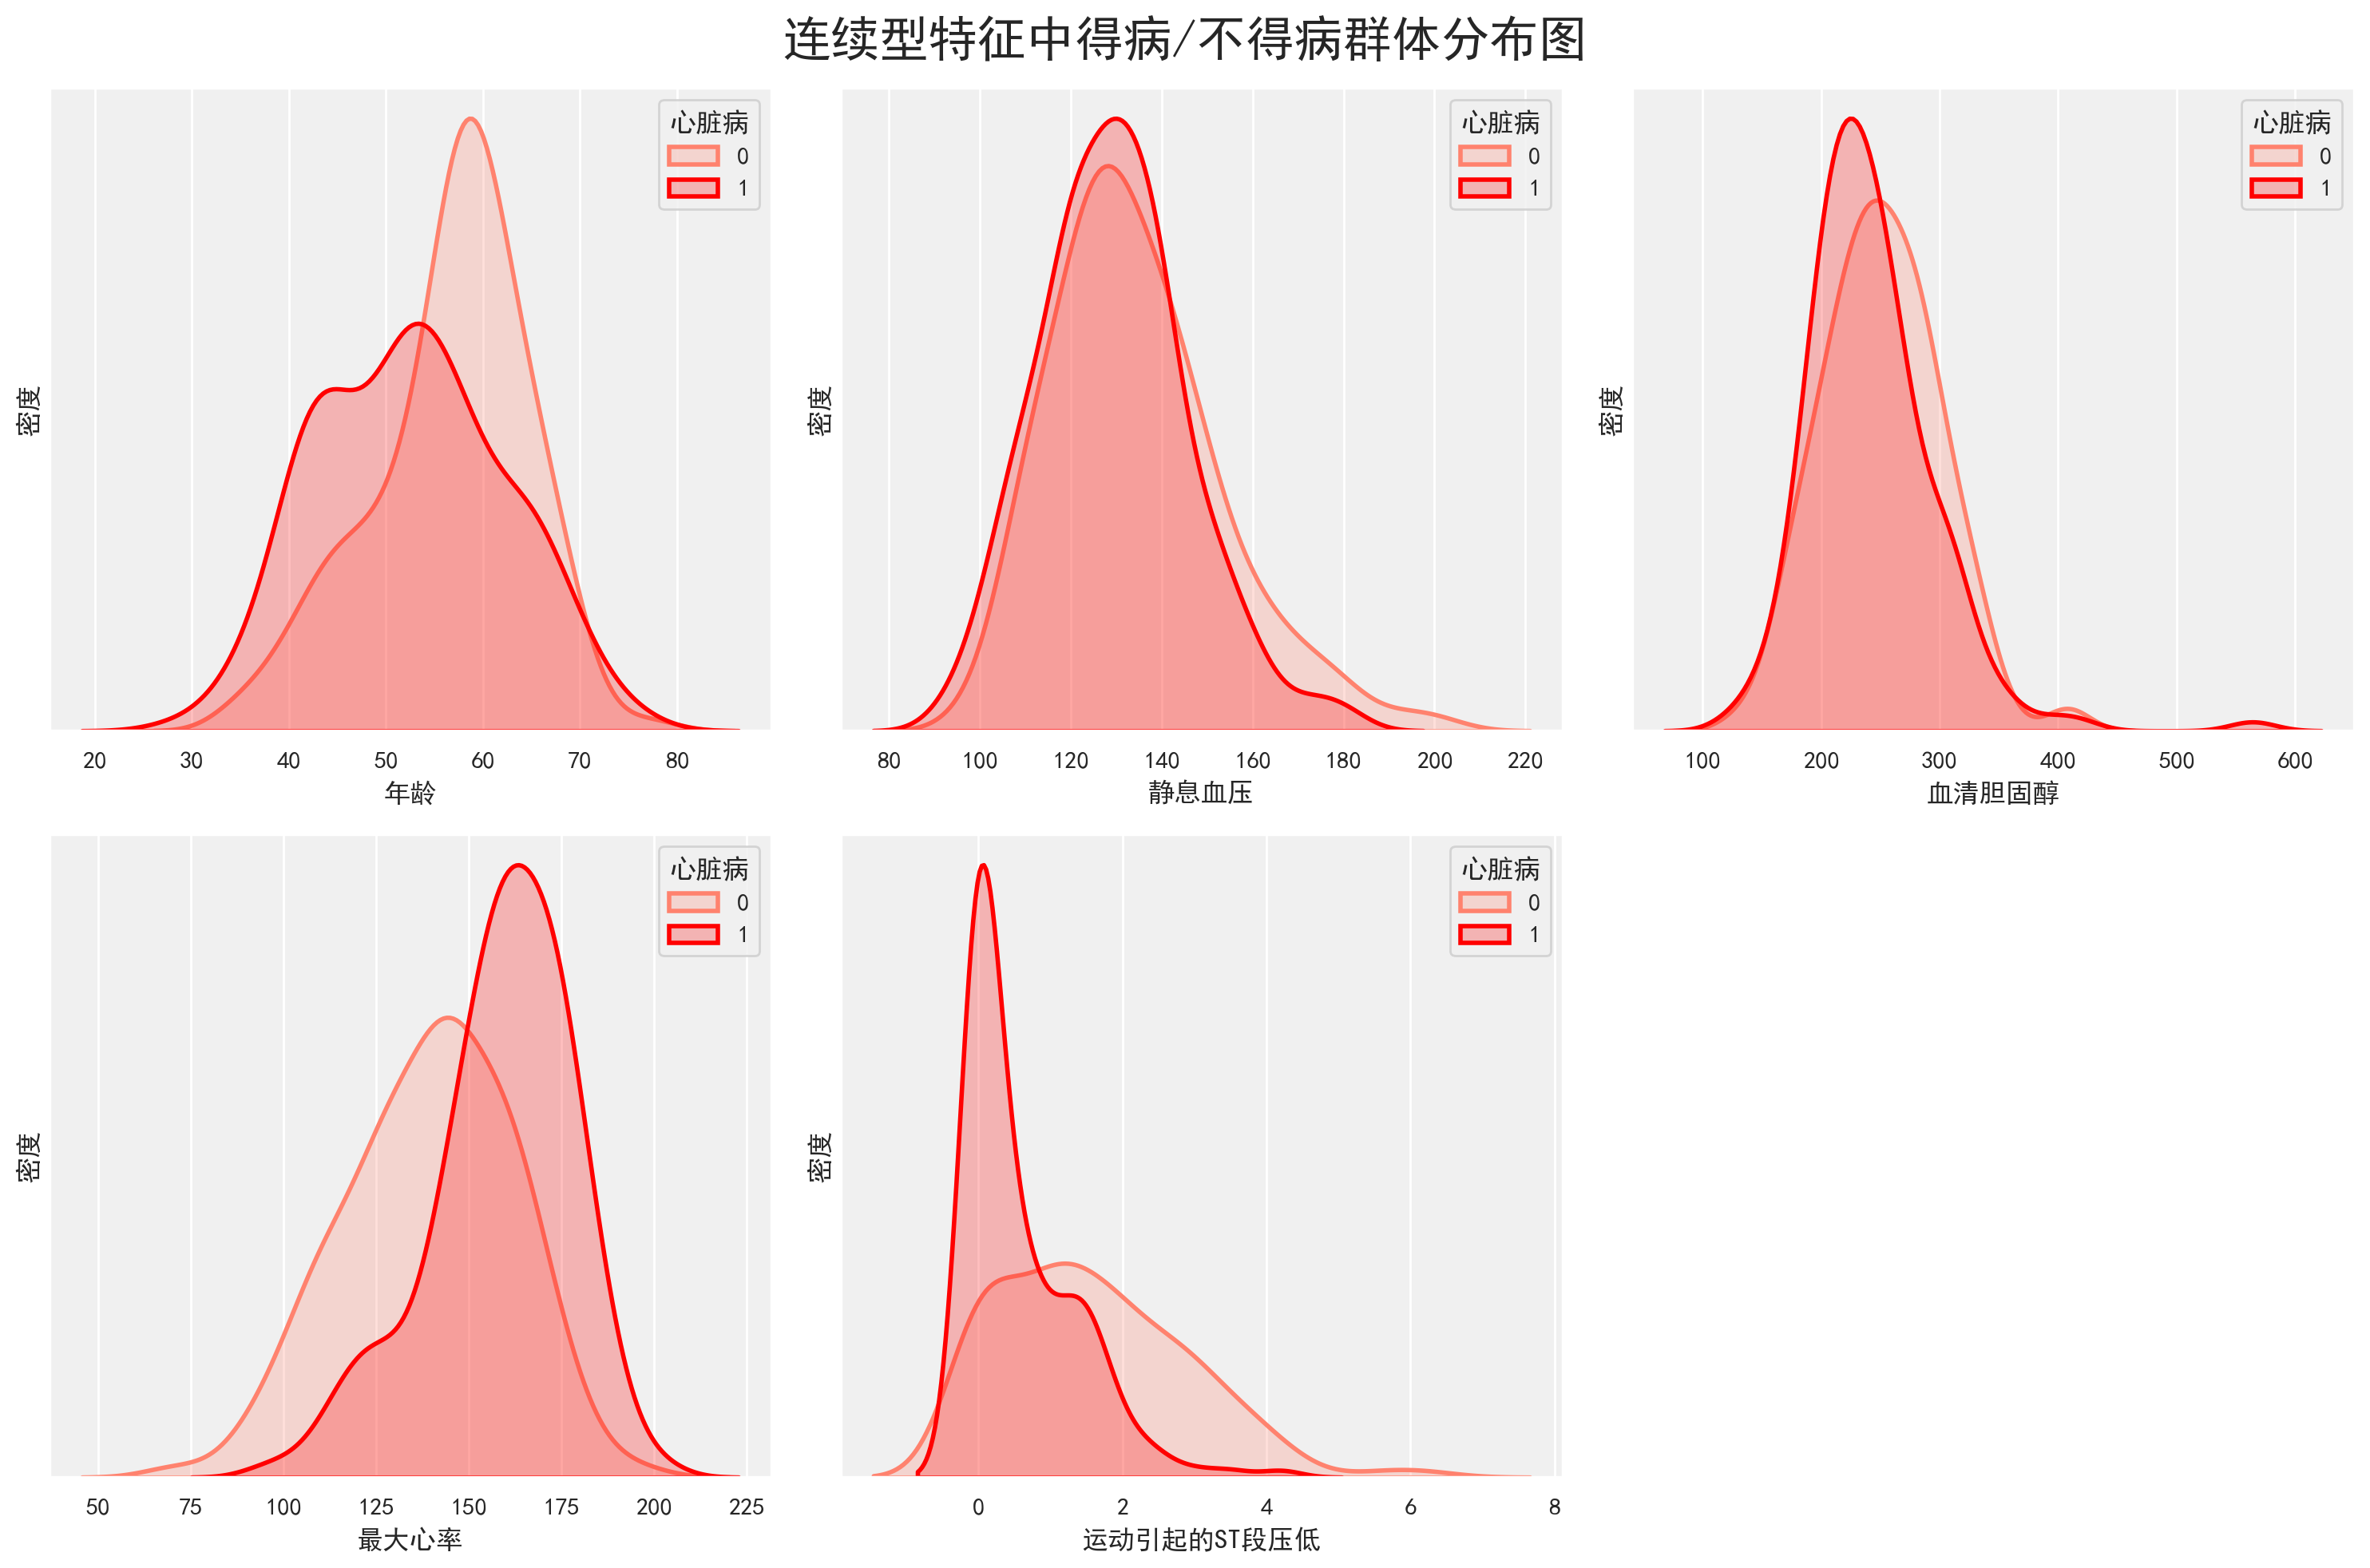

In [169]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    x = i // 3
    y = i % 3
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["是否得病"]==0], x=col, fill=True, linewidth=2, ax=ax[x,y], label='0')
    sns.kdeplot(data=df[df["是否得病"]==1], x=col, fill=True, linewidth=2, ax=ax[x,y], label='1')
    ax[x,y].set_yticks([])
    ax[x,y].legend(title='心脏病', loc='upper right')
    ax[x,y].set_ylabel('密度')
    
        
# Set the title for the entire figure
ax[1,2].axis('off') #不画最后一个子图
plt.suptitle('连续型特征中得病/不得病群体分布图', fontsize=22)
plt.tight_layout()                     
plt.show()

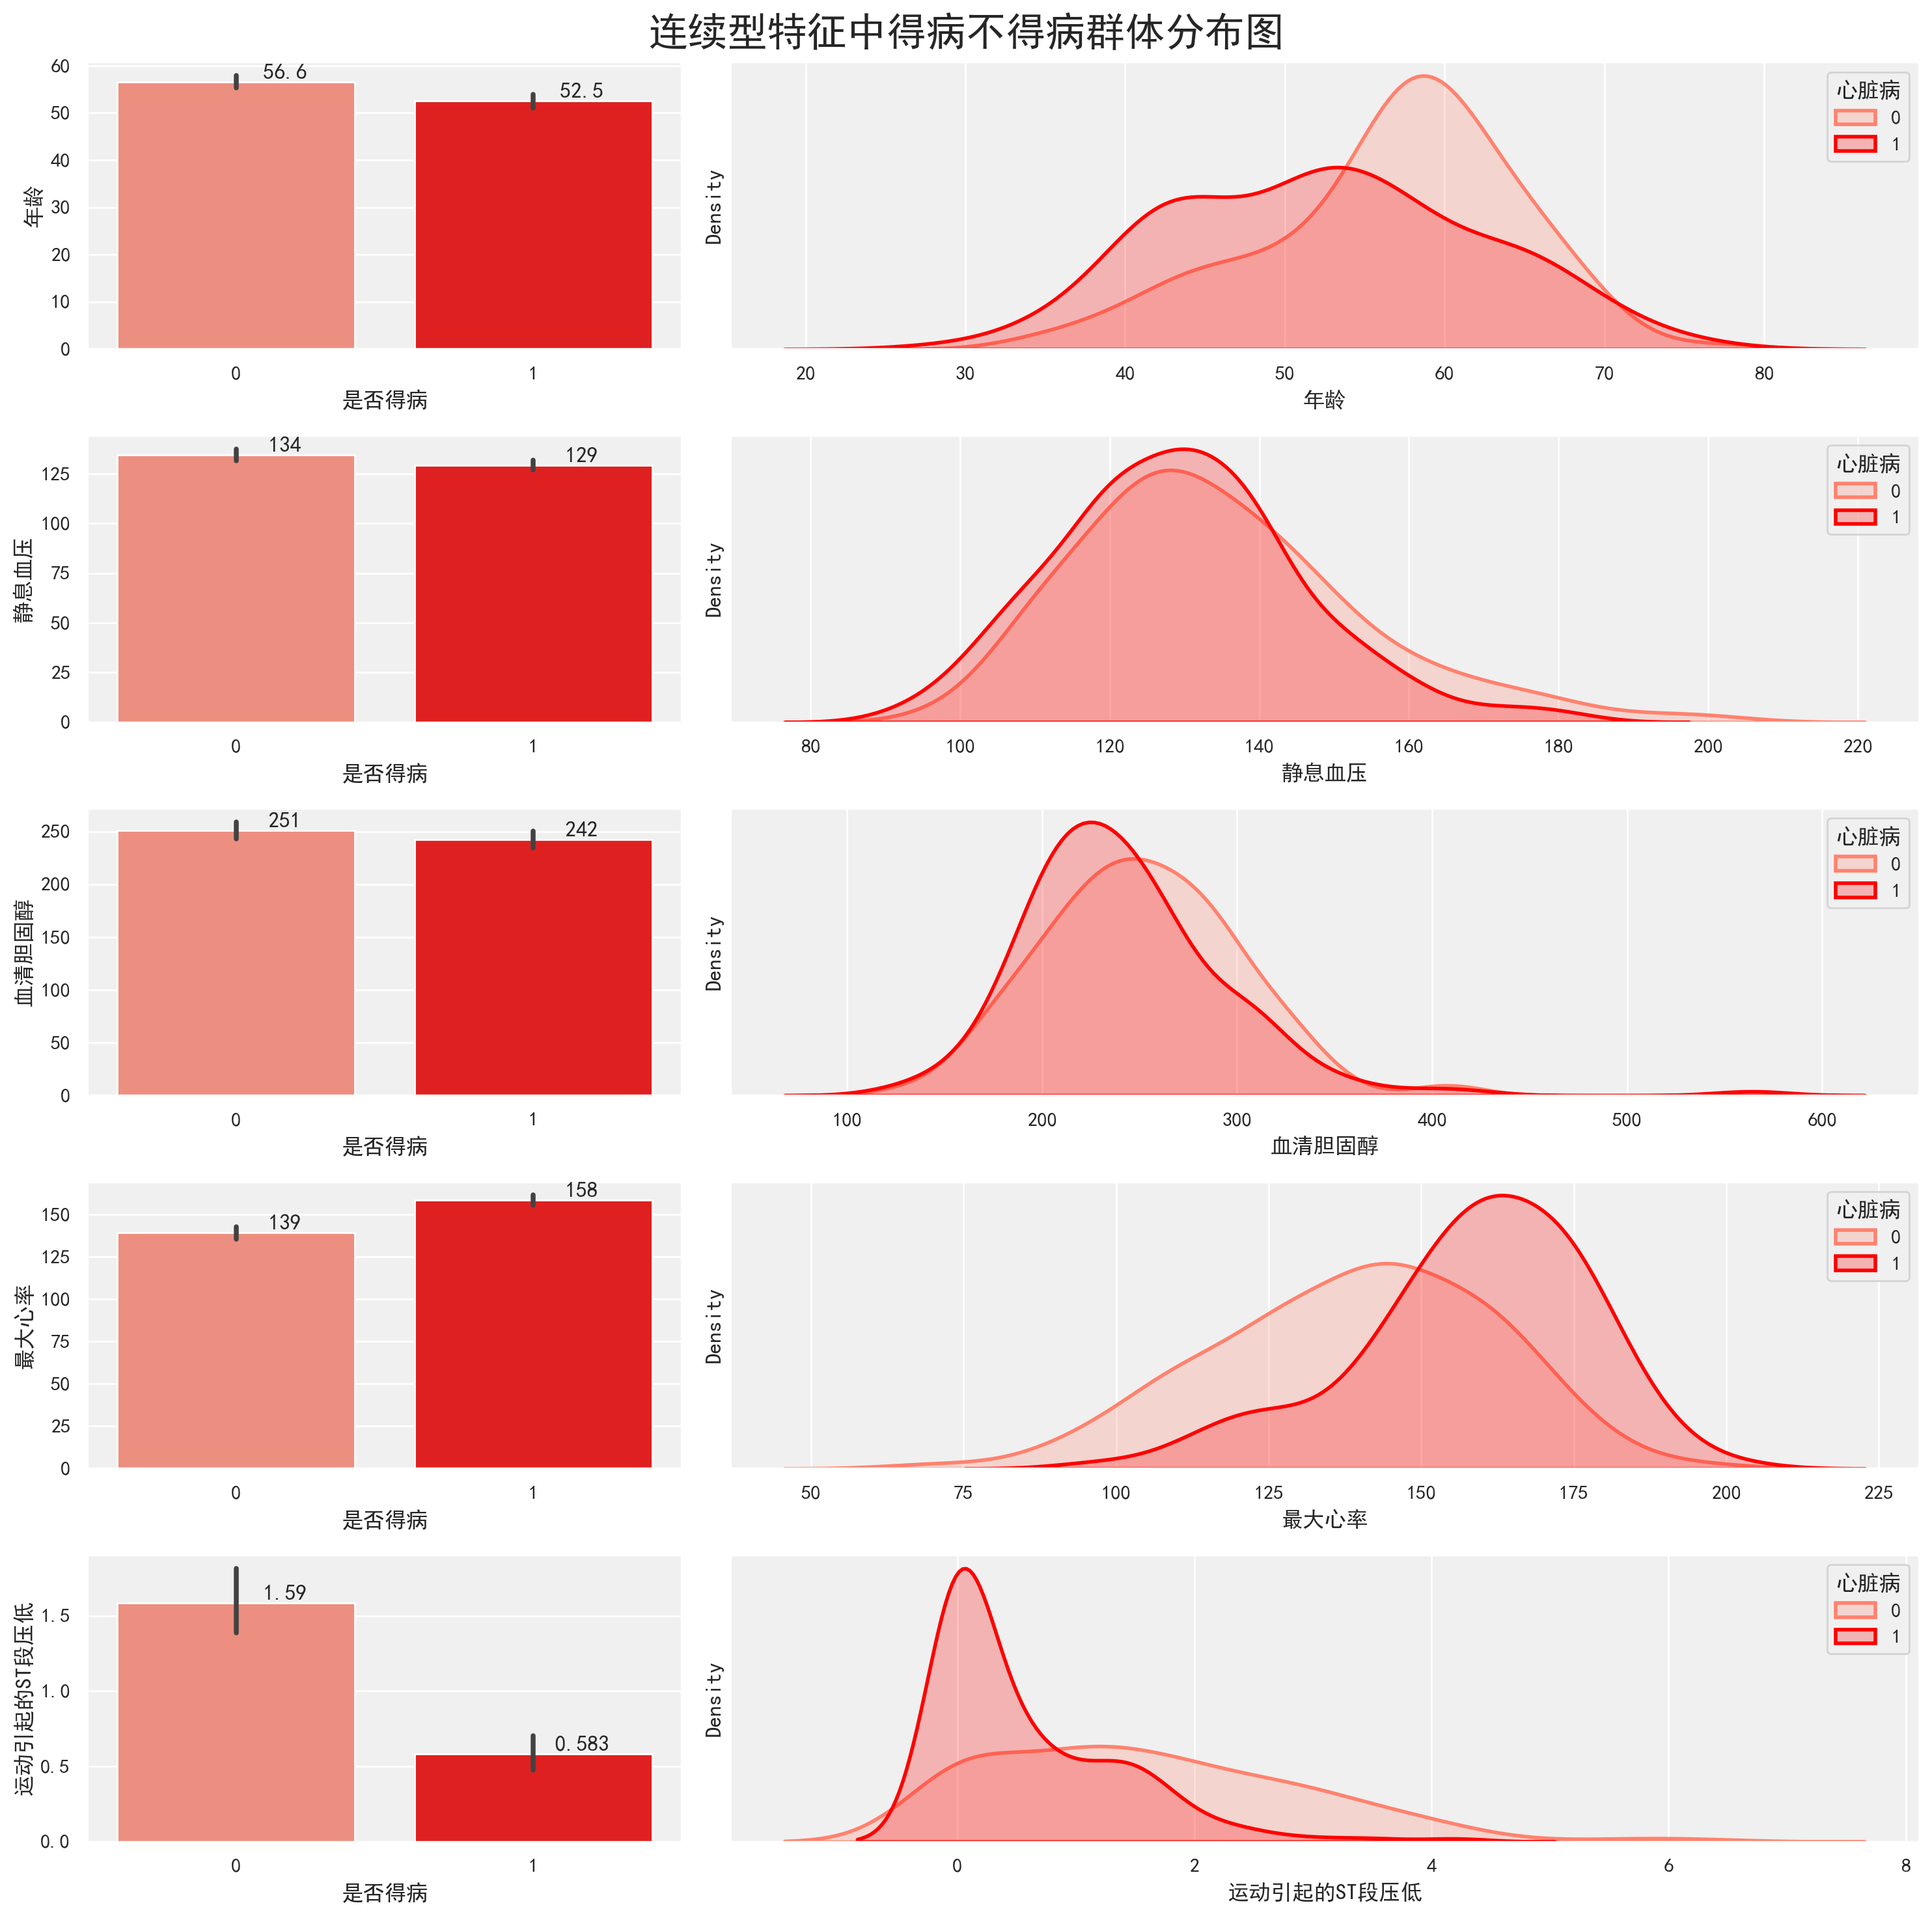

In [170]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="是否得病", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["是否得病"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["是否得病"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='心脏病', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('连续型特征中得病不得病群体分布图', fontsize=22)
plt.tight_layout()                     
plt.show()


#### **推论**：

* 年龄（age）：两类样本分布存在较为明显的差异，具体而言，患有心脏病的患者平均年龄更低。

* 静息血压（trestbps）：两类样本分布基本相同，表明此功能的区分能力有限。

* 血清胆固醇（chol）：两类胆固醇水平的分布较为接近，但心脏病患者的平均胆固醇水平略低。

* 最大心率（thalach）：两类样本分布存在较为明显的差异。与没有心脏病的样本相比，心脏病患者在压力测试中往往能达到更高的最大心率。

* 运动引起的ST段压低（oldpeak）：两类样本分布存在明显差异，相对于休息，运动引起的ST段压低对心脏病患者来说明显较低，而不患病样本的分布较为均匀。

根据分布和平均值的视觉差异，运动引起的ST段压低（oldpeak）似乎对心脏病状态的影响最大，其次是最大心率（thalach）和年龄（age）。

#### 4.2.3 分类型变量与结果变量的关系

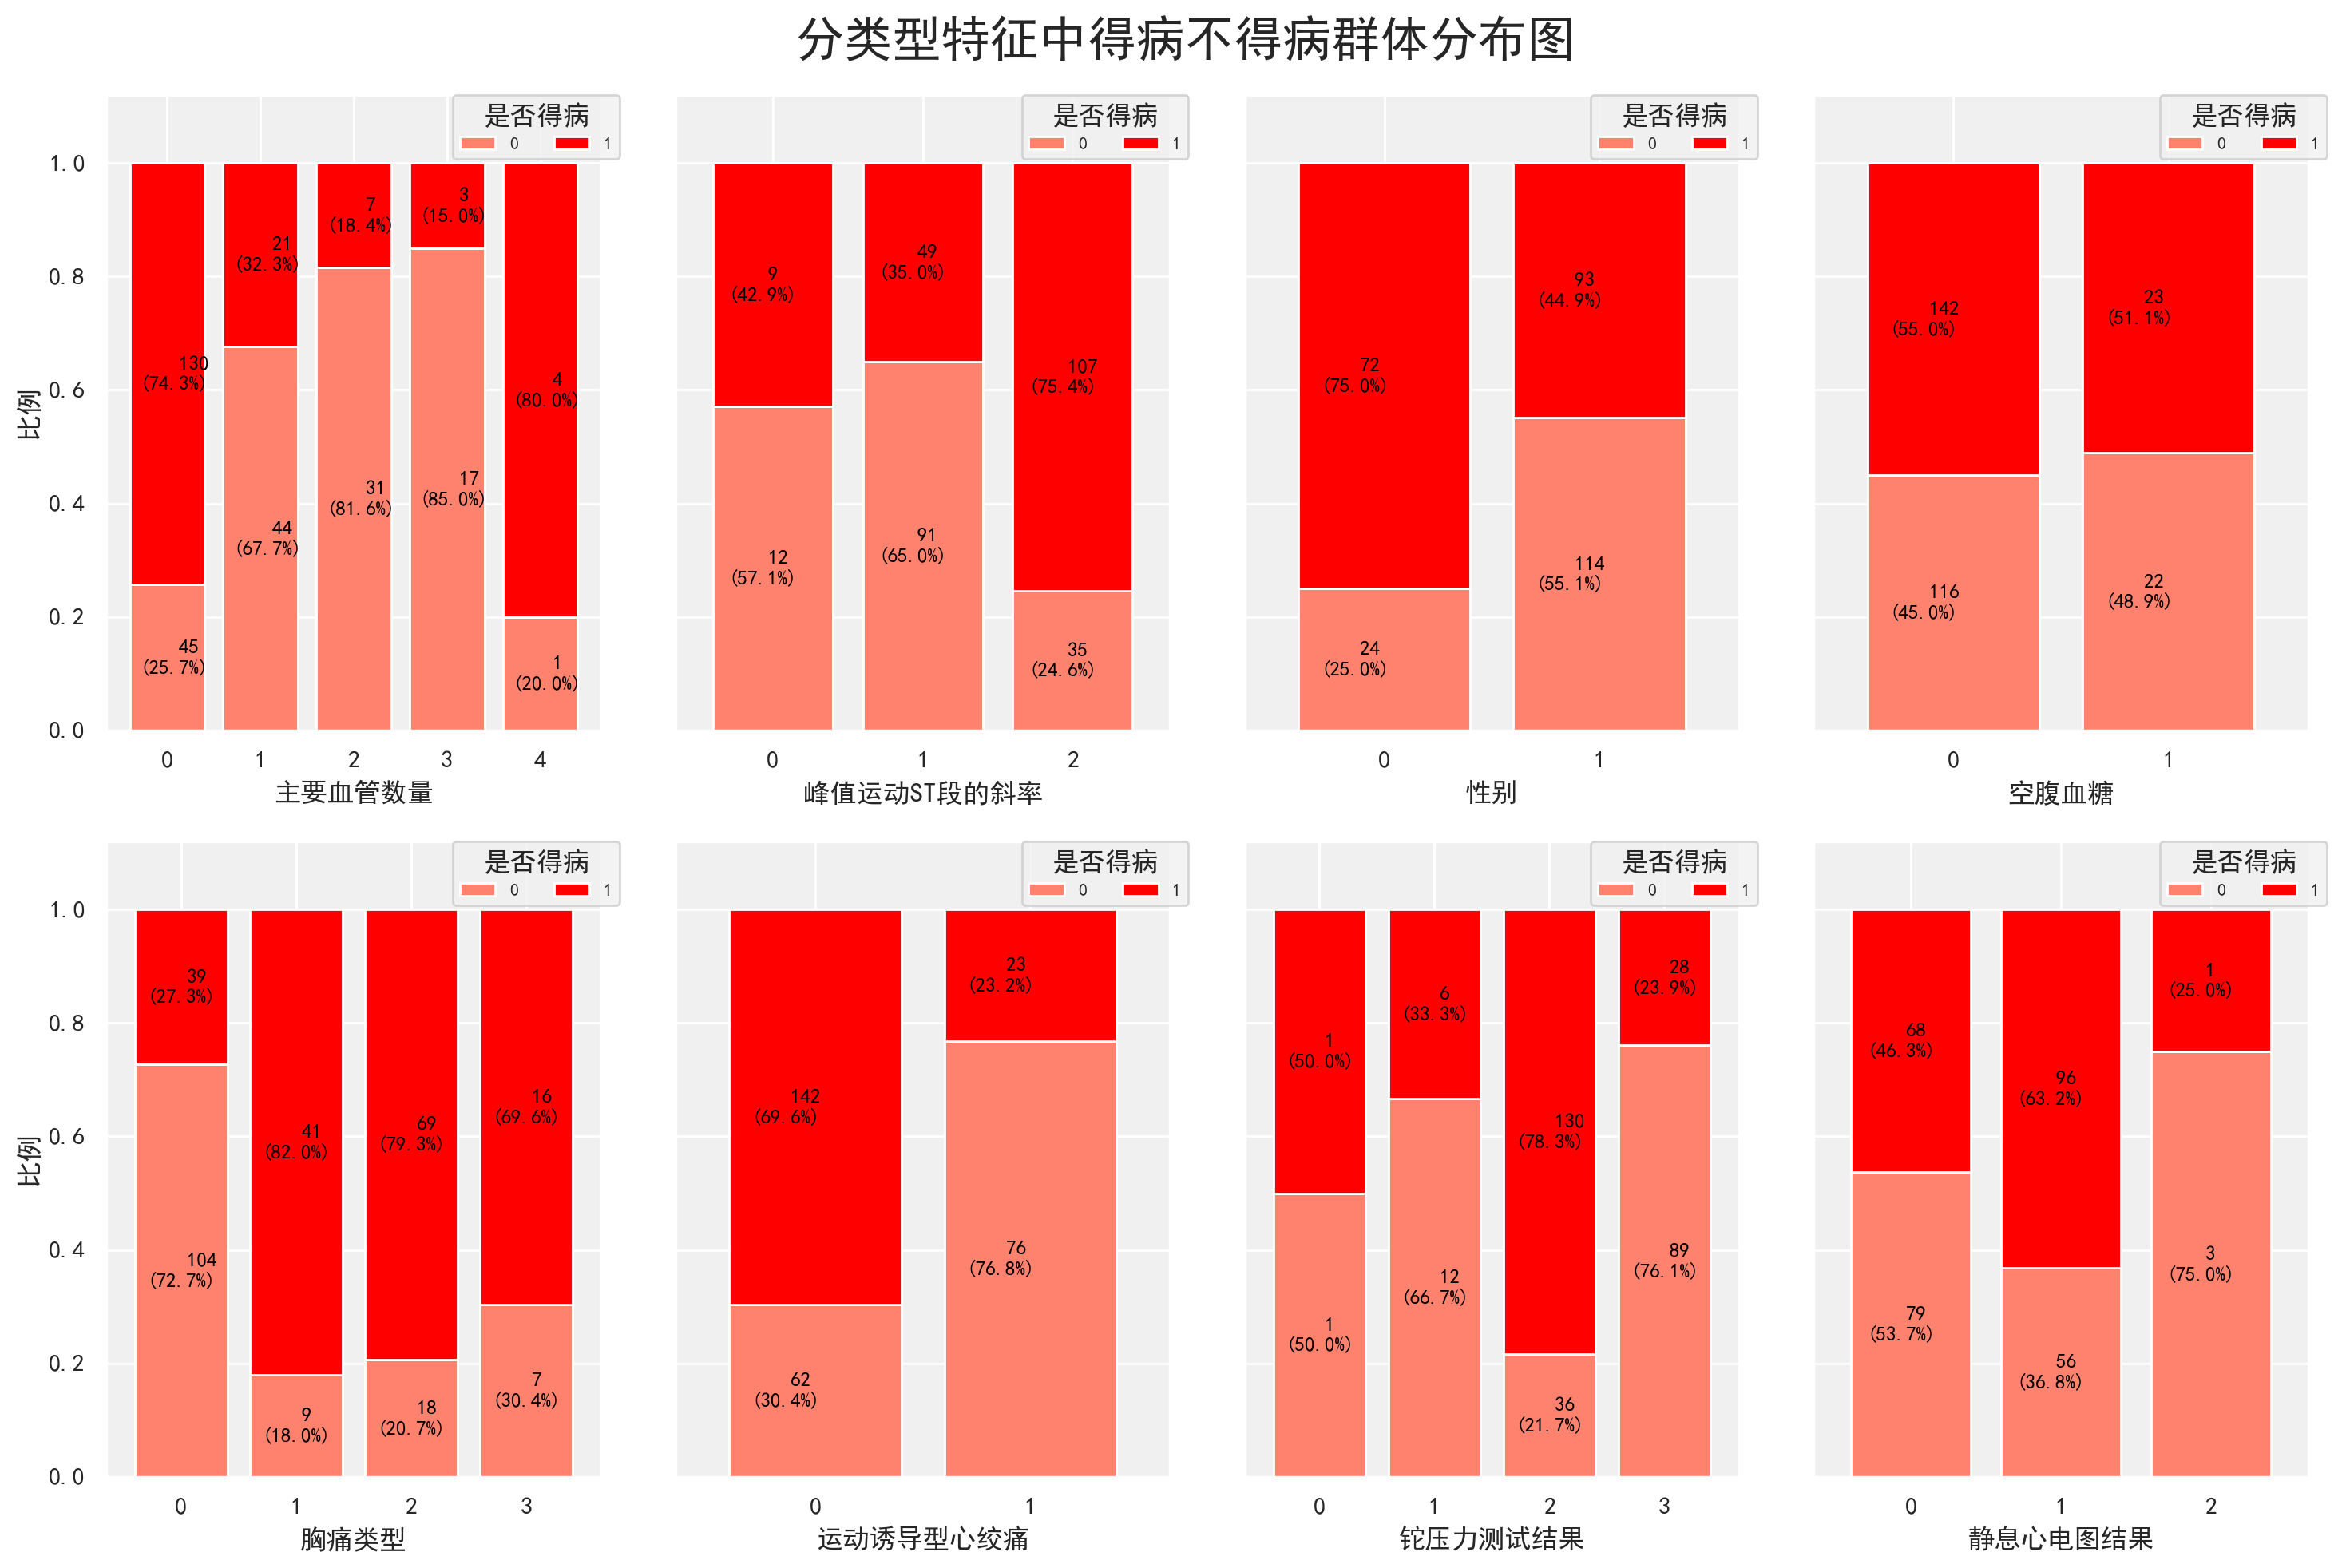

In [171]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['是否得病'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['是否得病'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='比例', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='是否得病', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('分类型特征中得病不得病群体分布图', fontsize=22)
plt.tight_layout()                     
plt.show()

#### **推论**：
* 主要血管数量（ca）：大多数心脏病患者通过荧光镜检查发现的主要血管较少。随着着色血管数量的增加，心脏病患者的比例趋于下降。但是，血管数量为0的样本患心脏病的比例更高。这表明ca是预测心脏病的重要影响因素。

* 胸痛类型（cp）：0型胸痛人群心脏病比例较低，而1，2，3型胸痛人群心脏病比例较高。这表明cp是预测心脏病的重要影响因素。

* 运动诱发的心绞痛（exang）：与运动诱发心绞痛（1）的样本相比，没有运动诱发的心绞痛（0）的样本中心脏病患者的比例更高。这表明exang是预测心脏病的重要影响因素。

* 空腹血糖（fbs）：空腹血糖>120mg/dl（1）的人和没有（0）的样本中患心脏病比例较为接近。这表明fbs对心脏病预测的影响可能有限。

* 静息心电图（restecg）：1型心电图样本心脏病的比例相对较高。这表明restecg对于预测心脏病有一定影响。

* 性别（sex）：与男性（0）相比，女性（1）患心脏病的比例较低。这表明sex是预测心脏病的重要影响因素。

* 峰值运动ST段斜率（slope）：斜率类型2的心脏病发病率明显较高。这表明slope是预测心脏病的重要影响因素。

* 铊压力测试结果（thal）：与其他类别相比，可逆型缺陷类别（2）的心脏病发病率更高。这表明thal是预测心脏病的重要影响因素。

总上所述，基于可视化结果：

高度影响目标：ca、cp、exang、sex、slope和thal

对目标的中度影响：restecg

对目标的影响较小：fbs

## 5.数据预处理

### 5.1 缺失值处理

In [172]:
# Check for missing values in the dataset
df.isnull().sum().sum()

0

数据无缺失值

### 5.2 异常值处理：

#### 5.2.1 检测异常值

* 由之前的箱型图可知，部分连续型变量具有异常值。

* 对于连续型变量使用IQR方法判断异常值：异常值被定义为那些低于Q1 - 1.5 × IQR或高于Q3 + 1.5 × IQR的数据点

In [173]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

年龄            0
静息血压          9
血清胆固醇         5
最大心率          1
运动引起的ST段压低    5
dtype: int64

#### 5.2.2 处理异常值

##### **常见异常值处理方法**：

* 去除异常值：直接删除超出定义范围的数据点，通常基于四分位数范围（IQR）等方法。

* 限制异常值：我们可以将异常值限制在某个阈值内，例如第1或第99百分位，而不是删除。

* 转换：应用log或Box-Cox等转换可以减少异常值的影响，使数据更像高斯。

* 鲁棒缩放：可以使用Scikit-learn中的RobustScaler等技术，该技术使用对异常值鲁棒的统计数据来缩放特征。

##### **选择方法**：
    由于数据集样本量较小，采用Box-Cox以及RobustScaler处理异常值。为避免使用测试集数据训练Box-Cox以及RobustScaler变换参数，将在最后分割训练集和测试集后再进行Box-Cox以及RobustScaler变换。此外Box-Cox变换还可以纠正偏斜的数据，使得数据分布更像正态分布。RobustScaler还可以将数据集缩放到统一尺度

### 5.3 对分类型数据编码

#### **独热编码决策**：

根据特征描述，让我们决定一种独热编码：

* 名义变量：这些是没有固有顺序的变量。它们应该是热编码的，因为将它们用作数字可能会给模型引入意外的顺序。

* 序数变量：这些变量具有固有的顺序。它们不一定需要进行热编码，因为它们的顺序可以为模型提供有意义的信息。

鉴于上述解释：

* sex：这是一个有两个类别（男性和女性）的二进制变量，所以它不需要一个热编码。

* cp：胸痛类型可以被认为是名义上的，因为不同类型的胸痛（如典型心绞痛、非典型心绞痛等）之间没有明确的顺序关系。它应该是一个热编码。

* fbs：这是一个二进制变量（真或假），所以它不需要一个热编码。

* restecg：该变量代表静息心电图结果。结果，如“正常”、“ST-T波异常”和“显示可能或明确的左心室肥大”，似乎没有顺序关系。因此，它应该是一个热编码。

* exang：这是一个二进制变量（是或否），所以它不需要一个热编码。

* slope：这表示峰值运动ST段的斜率。根据描述（上升、平坦、下降），它似乎具有有序性，表明了一种特定的顺序。因此，它不需要进行热编码。

* ca：这表示通过荧光透视着色的主要血管的数量。由于它表示计数，因此具有固有的顺序关系。因此，它不需要进行热编码。

* thal：这个变量代表铊压力测试的结果。不同的状态，如“正常”、“固定缺陷”和“可逆缺陷”，表明了一种名义性质。因此，它应该是一个热编码。

总结：

* 需要一个热编码：cp、restecg、thal

* 不需要一个热门编码：sex、fbs、exag、slope、ca

In [174]:
df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

In [175]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)
# 确定需要转换的独热编码列（可以根据列名模式识别）
one_hot_cols = [col for col in df_encoded.columns if col.startswith(('cp_', 'restecg_', 'thal_'))]
# 只将独热编码的列转换为int类型
df_encoded[one_hot_cols] = df_encoded[one_hot_cols].astype(int)
df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1           int32
cp_2           int32
cp_3           int32
restecg_1      int32
restecg_2      int32
thal_1         int32
thal_2         int32
thal_3         int32
dtype: object

In [176]:
# Displaying the resulting DataFrame after one-hot encoding
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0


### 5.5 纠正变量偏度

#### **转换倾斜特征**：

在预处理数据时，特别是应用Box-Cox等转换时，需要注意保持训练集、测试集参数一致，直接使用训练集的数据训练Box-Cox变换的参数\lambda应用与测试集，而非在测试集上重新训练参数，否则可能导致训练集、测试集分布不一致。

为了避免数据泄漏，并确保我们的模型能够很好地推广到地推广到看不到的数据：

1. 数据分割：我们首先将数据集分割成训练集和测试集。这确保了我们有一组单独的数据来评估模型的性能，在训练和预处理阶段不受影响。

2. Box-Cox变换：我们将研究训练集中连续特征的分布。如果它们出现偏斜，我们将应用Box-Cox变换来稳定方差，使数据更像正态分布。重要的是，我们将仅根据训练数据确定Box-Cox变换参数。

3. 将转换应用于测试数据：一旦从训练集中确定了转换参数，我们将使用这些精确的参数来转换我们的验证/测试集。这种方法确保验证/测试集中的信息不会泄露到我们的培训过程中。

4. 超参数调整和交叉验证：考虑到我们的数据集的大小，为了在模型训练阶段充分利用可用数据，我们将对训练集进行交叉验证以进行超参数调整。这使我们能够更好地了解我们的模型在看不见的数据上的表现，而无需实际使用测试集。测试集在此阶段保持不变，仅用于评估最终模型的性能。

通过遵循这种结构化的方法，我们确保了严格的训练过程，最大限度地降低了数据泄露的风险，并使自己能够对模型在看不见的数据上的性能进行现实的衡量。

In [177]:
# Define the features (X) and the output labels (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [178]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Box-Cox变换要求所有数据严格为正。为了使用Box-Cox变换oldpeak特征，我们可以添加一个小常数（例如0.001）以确保所有值都是正的：

In [179]:
# Adding a small constant to 'oldpeak' to make all values positive
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

In [180]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]


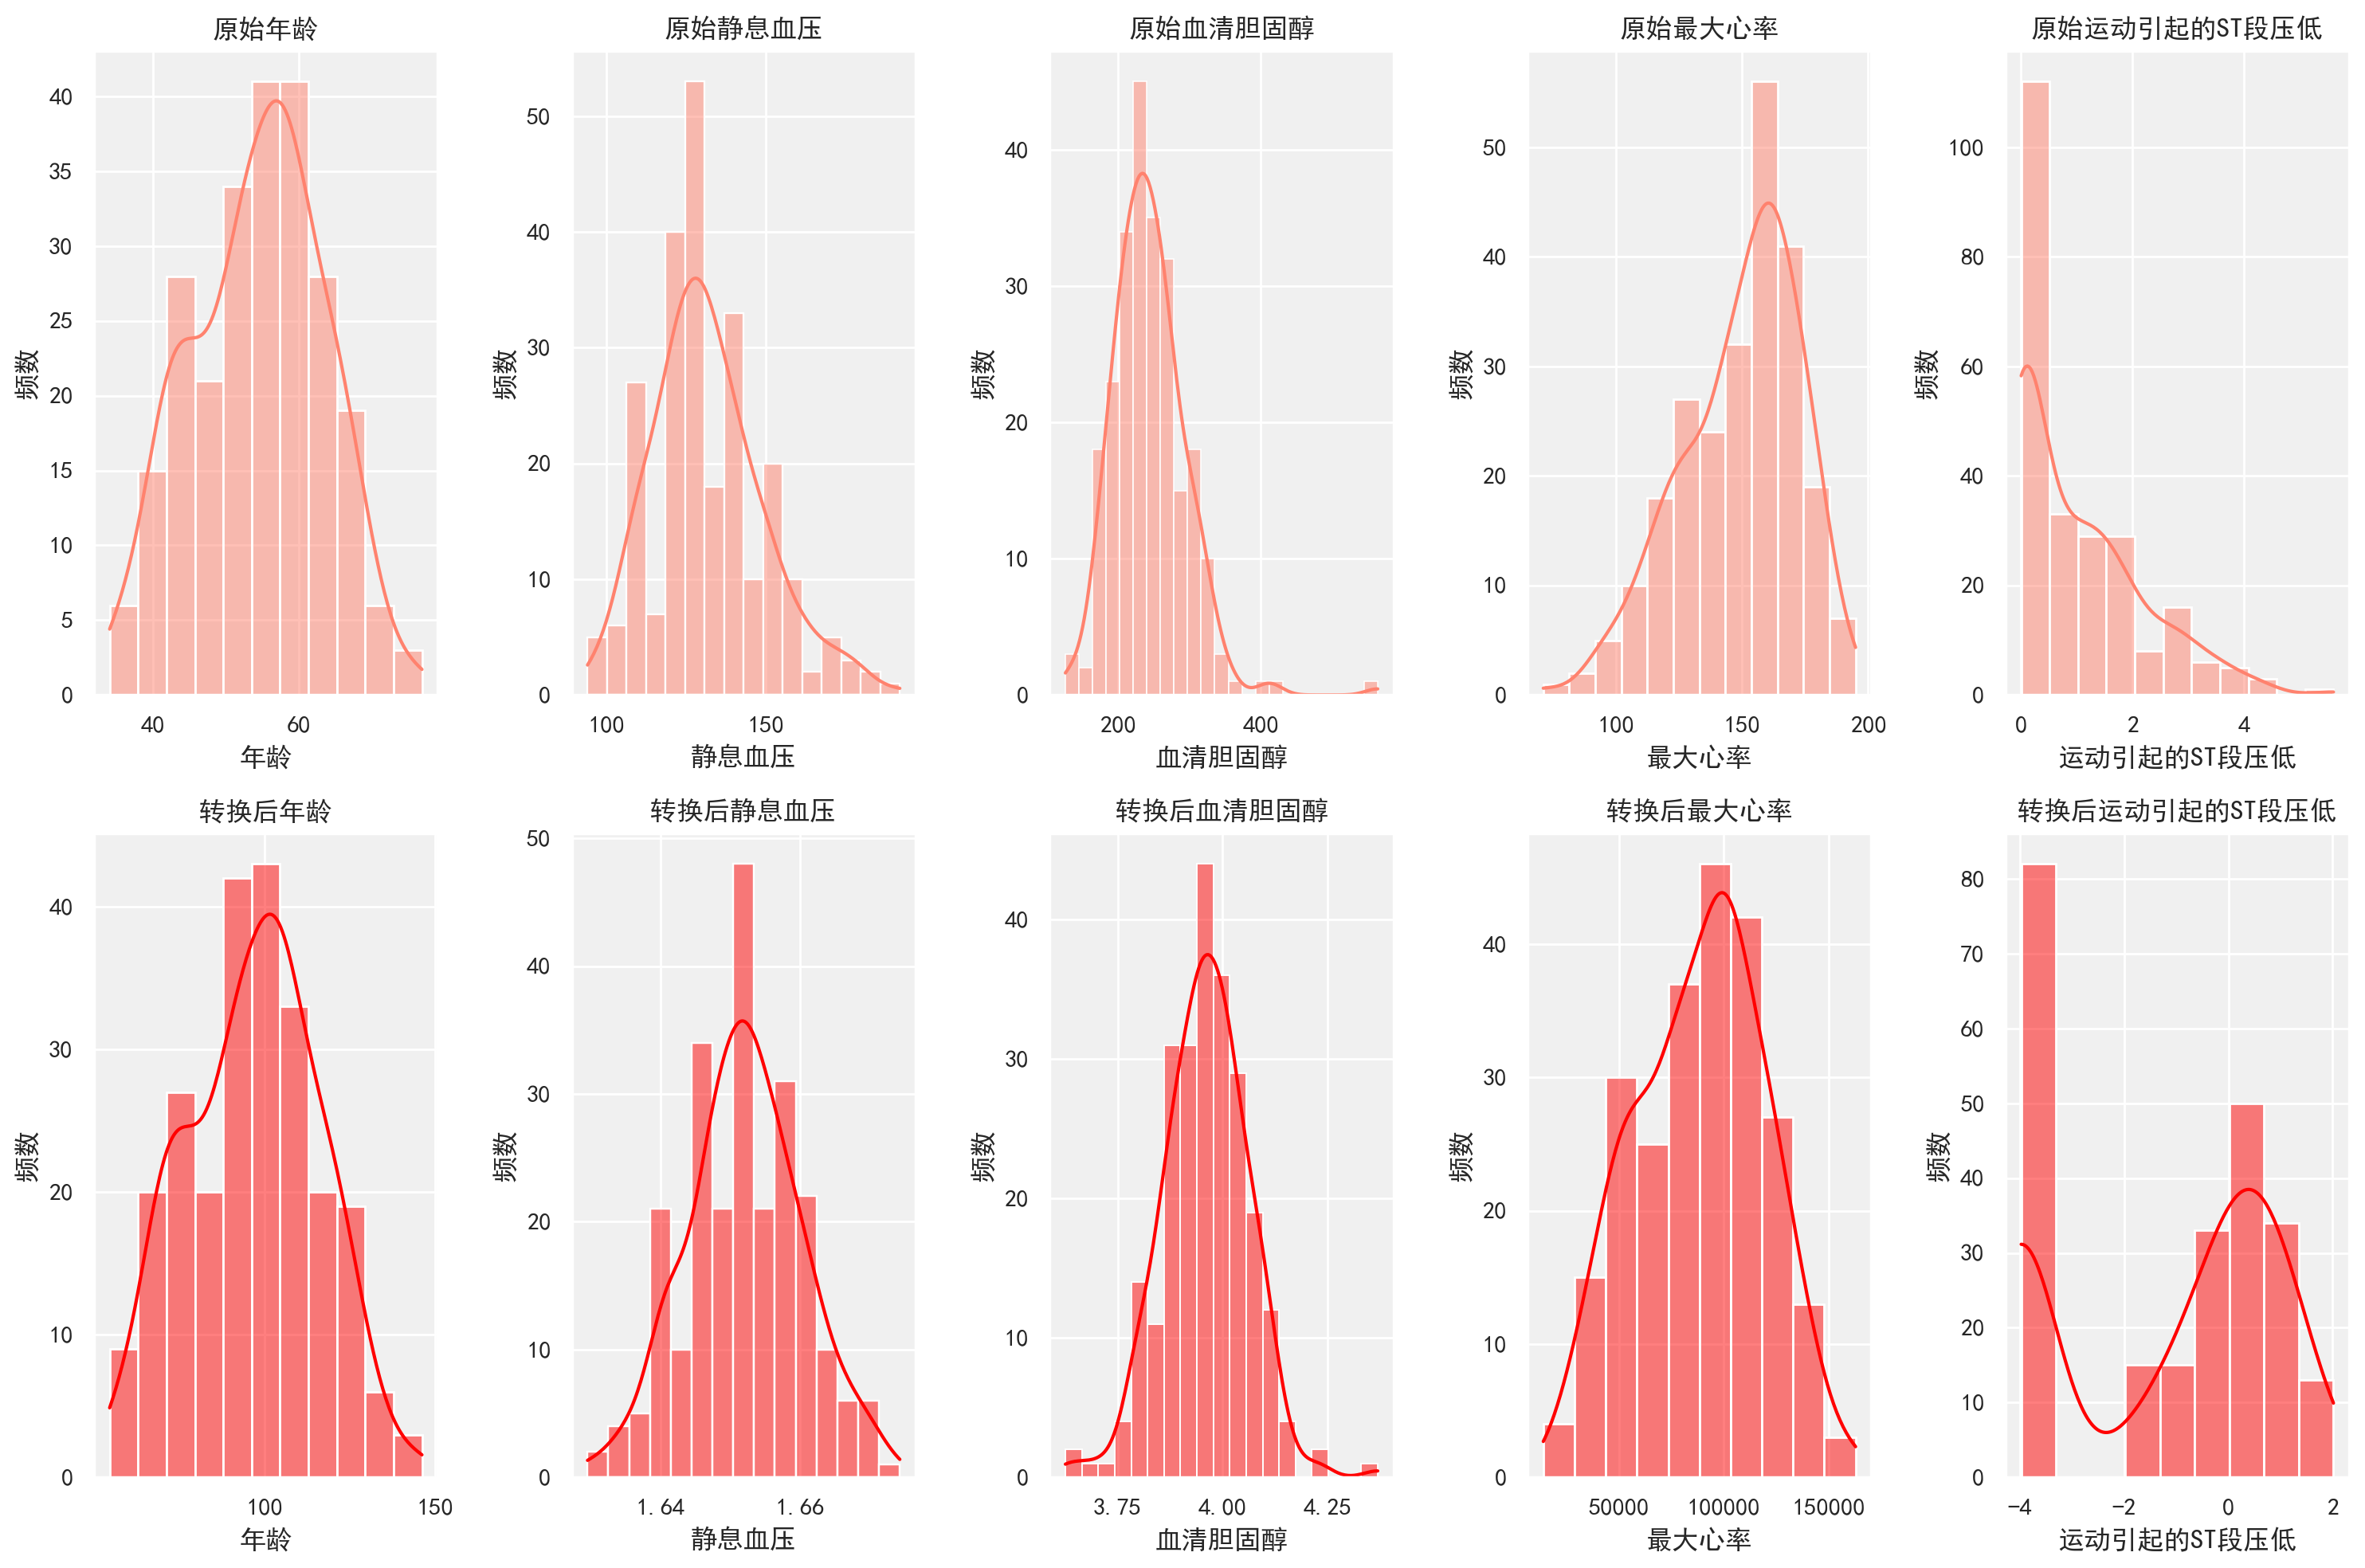

In [181]:

# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 5, figsize=(15,10))
title_col = ['年龄','静息血压','血清胆固醇','最大心率','运动引起的ST段压低']
# Original Distributions
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'原始{title_col[i]}')
    ax[0,i].set_xlabel(title_col[i])  # 设置子图横坐标标题
    ax[0,i].set_ylabel('频数')  # 设置子图纵坐标标题
    

# Applying Box-Cox Transformation
# Dictionary to store lambda values for each feature
lambdas = {}

for i, col in enumerate(continuous_features):
    # Only apply box-cox for positive values
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        # Applying the same lambda to test data
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col]) 
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'转换后{title_col[i]}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{title_col[i]} (未转换)')
    ax[1,i].set_xlabel(title_col[i])  # 设置子图横坐标标题
    ax[1,i].set_ylabel('频数')  # 设置子图纵坐标标题

fig.tight_layout()
plt.show()

In [182]:
X_train

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,99.775363,1,1.652121,4.044511,1,34193.227632,1,0.490856,0,0,0,0,0,0,0,0,0,1
191,104.060287,1,1.651135,3.909224,0,61564.640490,1,0.846853,1,3,0,0,0,0,0,0,0,1
15,87.096593,0,1.646937,3.916243,0,97354.894861,0,0.490856,1,0,0,1,0,1,0,0,1,0
224,95.519188,1,1.641028,3.960431,0,55975.891019,1,1.130195,1,1,0,0,0,1,0,0,0,1
250,89.190732,1,1.656716,4.069855,0,51729.486474,1,1.634849,1,3,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,70.638724,0,1.646937,3.892411,0,121529.655503,0,-3.979618,1,0,0,1,0,1,0,0,1,0
33,95.519188,1,1.649610,4.026760,0,88560.678743,0,-0.650415,0,1,0,1,0,0,0,0,1,0
181,119.272698,0,1.660823,3.929961,0,43823.462411,0,0.001000,1,3,0,0,0,0,0,0,0,1
262,93.402149,1,1.648562,4.042768,0,28058.867965,1,0.738182,1,2,0,0,0,1,0,0,0,1


分析上图可知：除了oldpeak变量，其余变量经过box-cox变换后分布近似为正态分布。

### 5.4 数据标准化

特征缩放是对特征幅度或规模敏感的算法的关键预处理步骤。SVM、KNN和许多线性模型等模型依赖于距离或梯度，这使得它们容易受到特征尺度变化的影响。缩放可确保所有特征对模型的决策都有同等的贡献，而不是被幅度较大的特征所主导。

为避免异常值的影响，采用RobustScaler标准化方法

In [183]:
# Apply RobustScaler to handle outliers
scaler = RobustScaler()
select_columns = continuous_features+['slope','ca']
# Fit the scaler to the data
scaler.fit(X_train[select_columns])
# Transform the data
X_train[select_columns] = scaler.transform(X_train[select_columns])
X_test[select_columns] = scaler.transform(X_test[select_columns])



### 5.6 将数据预先处理封装成类

由于不同数据处理函数所处理的对象均是同一数据，但是对于建立不同模型，需要的数据处理不同，因此可以将数据预处理封装成类，在建立不同模型时，按照需要实例化该类即可。

In [184]:
class Heart_Data_Process:
        def __init__(self, df):
            """
            初始化数据预处理器。
            """
            self.data = df

        def Encode(self):
            # Implementing one-hot encoding on the specified categorical features
            self.data = pd.get_dummies(self.data, columns=['cp', 'restecg', 'thal'], drop_first=True)
            
            # Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
            features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
            for feature in features_to_convert:
                self.data[feature] = self.data[feature].astype(int)
            # 确定需要转换的独热编码列（可以根据列名模式识别）
            one_hot_cols = [col for col in df_encoded.columns if col.startswith(('cp_', 'restecg_', 'thal_'))]
            # 只将独热编码的列转换为int类型
            self.data[one_hot_cols] = self.data[one_hot_cols].astype(int)
            # Define the features (X) and the output labels (y)
            X = self.data.drop('target', axis=1)
            y = self.data['target'] 
            # Splitting data into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
            self.X_train = X_train
            self.y_train = y_train
            self.X_test = X_test
            self.y_test = y_test
            
        def Box_Cox(self):
            # Adding a small constant to 'oldpeak' to make all values positive
            self.X_train['oldpeak'] = self.X_train['oldpeak'] + 0.001
            self.X_test['oldpeak'] = self.X_test['oldpeak'] + 0.001
            # Applying Box-Cox Transformation
            # Dictionary to store lambda values for each feature
            lambdas = {}
            # Define the continuous features
            continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
            for i, col in enumerate(continuous_features):
                # Only apply box-cox for positive values
                if self.X_train[col].min() > 0:
                    self.X_train[col], lambdas[col] = boxcox(self.X_train[col])
                    # Applying the same lambda to test data
                    self.X_test[col] = boxcox(self.X_test[col], lmbda=lambdas[col])

        def Robust_Scaler2(self):
            # Apply RobustScaler to handle outliers
            scaler = RobustScaler()
            # Fit the scaler to the data
            scaler.fit(self.X_train)
            
            # Transform the data
            X_train_scaled = scaler.transform(self.X_train)
            X_test_scaled = scaler.transform(self.X_test)

            # 将 numpy arrays 转换回 pandas DataFrames
            self.X_train = pd.DataFrame(X_train_scaled, columns=self.X_train.columns)
            self.X_test = pd.DataFrame(X_test_scaled, columns=self.X_test.columns)

        
        def Robust_Scaler(self):
            # Apply RobustScaler to handle outliers
            scaler = RobustScaler()
            continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
            select_columns = continuous_features+['slope','ca']
            # Fit the scaler to the data
            scaler.fit(self.X_train[select_columns])
            # Transform the data
            self.X_train[select_columns] = scaler.transform(self.X_train[select_columns])
            self.X_test[select_columns] = scaler.transform(self.X_test[select_columns])


## 6.模型建立

**注意**：在医疗场景中，特别是在诊断疾病的情况下，对阳性类别（患有这种疾病的患者）的召回率通常更重要。高召回率确保了大多数实际阳性病例被正确识别，即使这意味着一些假阳性（健康个体被错误分类为患有这种疾病的病例）。其基本原理是，有一些误报通常比错过诊断潜在疾病的患者要好。

In [185]:
#调参函数
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3,method = 'Random'):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest recall for class 1 is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    if method == 'Random':
        # Create the RandomizedSearchCV object
        clf_grid = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=100, cv=cv, scoring=scoring, n_jobs=-1)
    elif method == 'Grid':
        # Create the GridSearchCV object
        clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring,n_jobs=-1)
    else:
        raise ValueError(f"Invalid method choice: {method}. Please choose 'Random' or 'not Random'.")

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [186]:
#评价函数
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred),
        "auc" : roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    }
    fpr, tpr, thresholds = roc_curve(y_test,  model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC曲线(AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 绘制随机猜测的参考线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('假阳性率（FPR）')
    plt.ylabel('真阳性率（TPR）')
    plt.title('受试者工作特性（ROC）曲线')
    plt.legend(loc="lower right")
    plt.grid(color='white', linestyle='-', linewidth=0.7)  # 设置白色网格
    plt.show()
    
    # Convert dictionary to dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

### 6.1 K最近邻回归

### 6.1 K最近邻回归

#### 6.1.1 数据准备

##### **KNN算法**：
* 需要标准化：通常使用欧几里得距离（Euclidean distance）作为度量，它对特征的尺度敏感。如果特征没有被标准化，那么尺度较大的特征对距离的影响更大。
* 采用对异常值稳健的标准化方法：KNN对异常值很敏感，因为它依赖于数据点之间的距离来进行预测。异常值会扭曲这些距离。


In [187]:
mydf = Heart_Data_Process(df)
mydf.Encode()
mydf.Box_Cox()
mydf.Robust_Scaler()
X_train = mydf.X_train
X_test = mydf.X_test
y_train = mydf.y_train
y_test = mydf.y_test

#### 6.1.2 调参

In [188]:
# Define

knn_base = KNeighborsClassifier()

In [189]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'n_neighbors': list(range(1, 20)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [190]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_base, knn_param_grid, X_train, y_train,method = 'Grid')
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


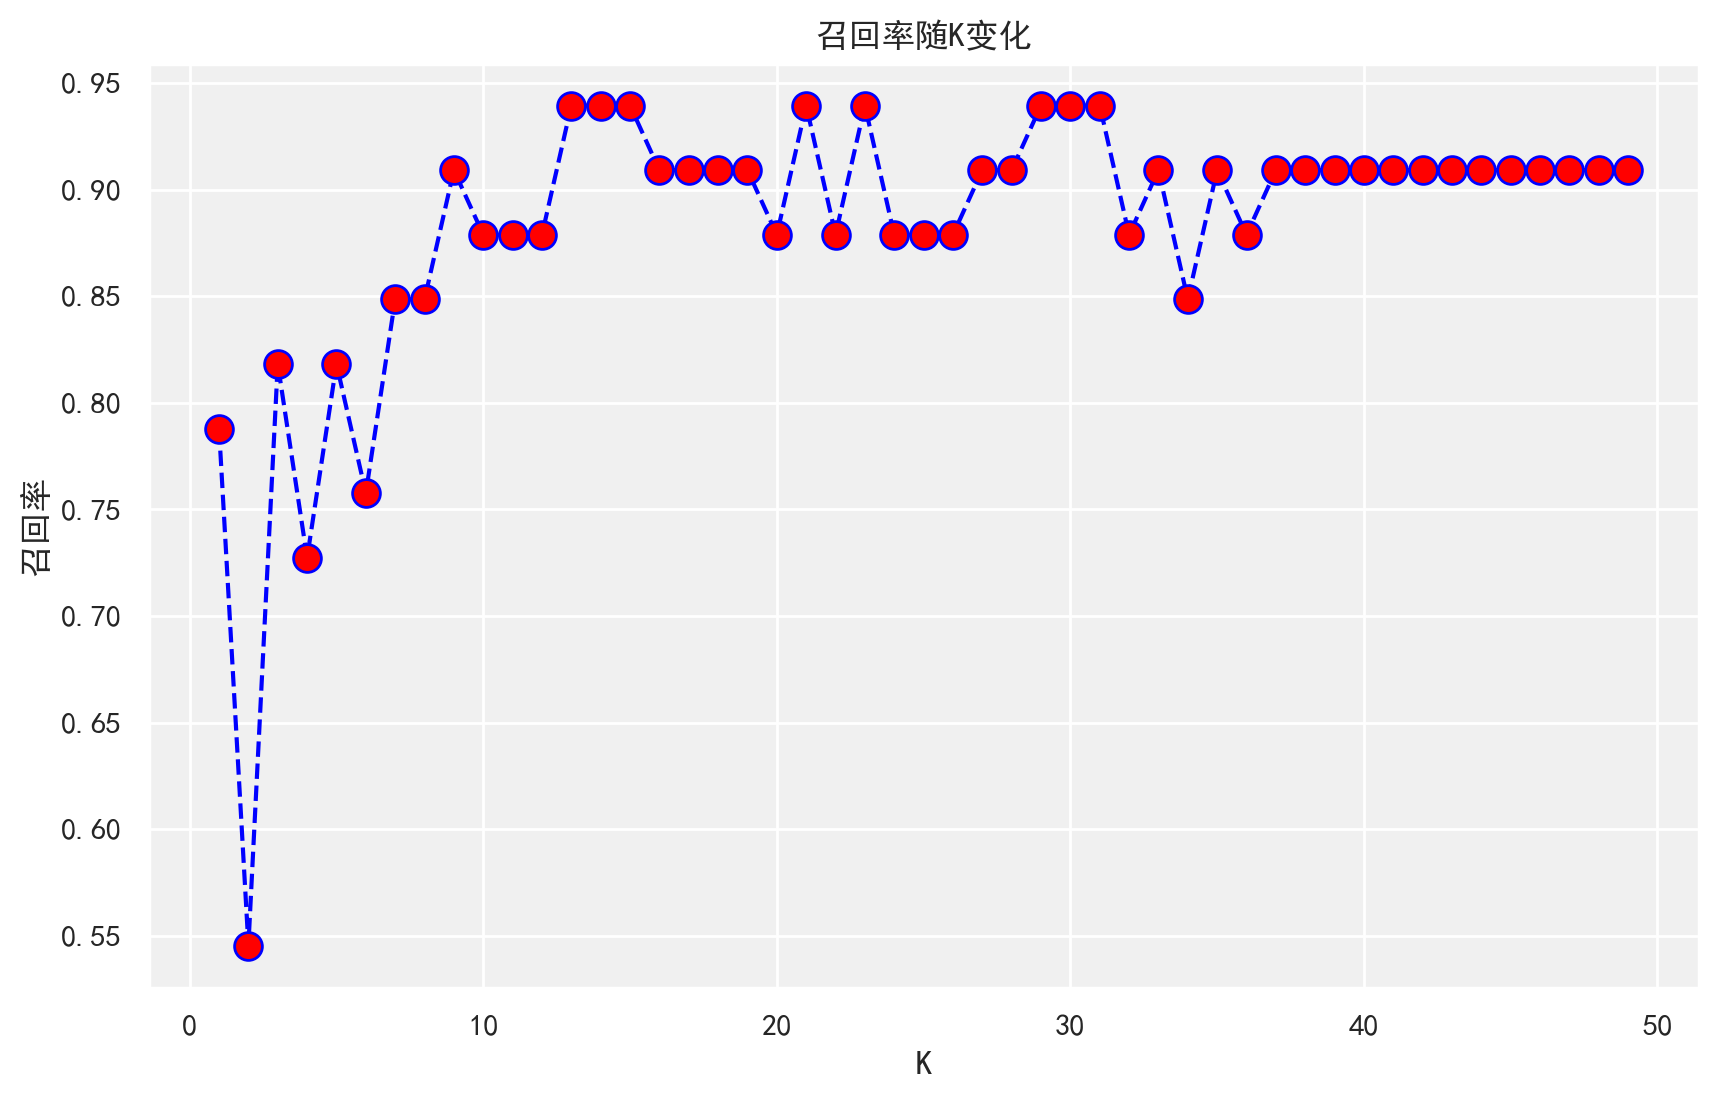

In [191]:
# Choose the best K value
recall = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    recall.append(recall_score(y_test,pred_i))

# Plot the error rates versus the K values
plt.figure(figsize=(10,6))
plt.plot(range(1,50),recall, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=10)
plt.title('召回率随K变化')
plt.xlabel('K')
plt.ylabel('召回率')
plt.show()

#### 6.1.3 模型评价

测试集表现

In [192]:
# confusion_matrix
cm = confusion_matrix(y_test, best_knn.predict(X_test))
print(cm)

[[24  4]
 [ 3 30]]


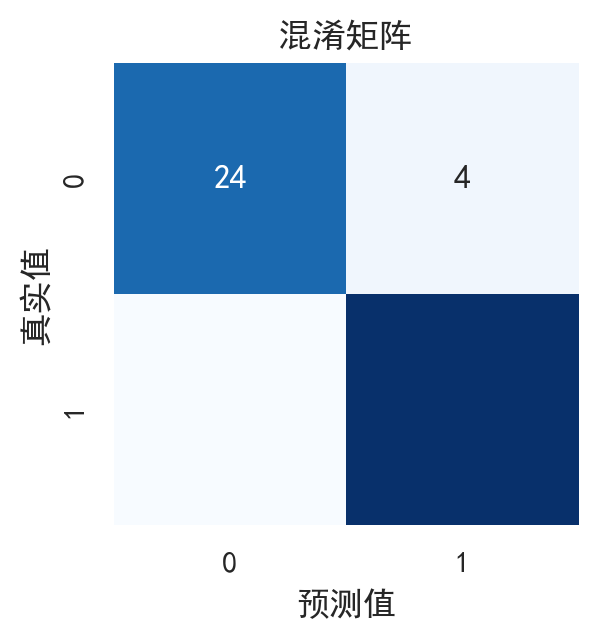

In [193]:
# 使用seaborn的heatmap函数来绘制混淆矩阵
plt.figure(figsize=(3,3))  # 设置图形的大小
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.title('混淆矩阵')
plt.show()

In [194]:
precision = precision_score(y_test, best_knn.predict(X_test))
recall = recall_score(y_test, best_knn.predict(X_test))
f1 = f1_score(y_test, best_knn.predict(X_test))
Auc = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {Auc}")

Precision: 0.8823529411764706
Recall: 0.9090909090909091
F1 Score: 0.8955223880597014
AUC: 0.9242424242424242


In [195]:
y_scores = best_knn.predict_proba(X_test)[:, 1]  # 获取正类的概率
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

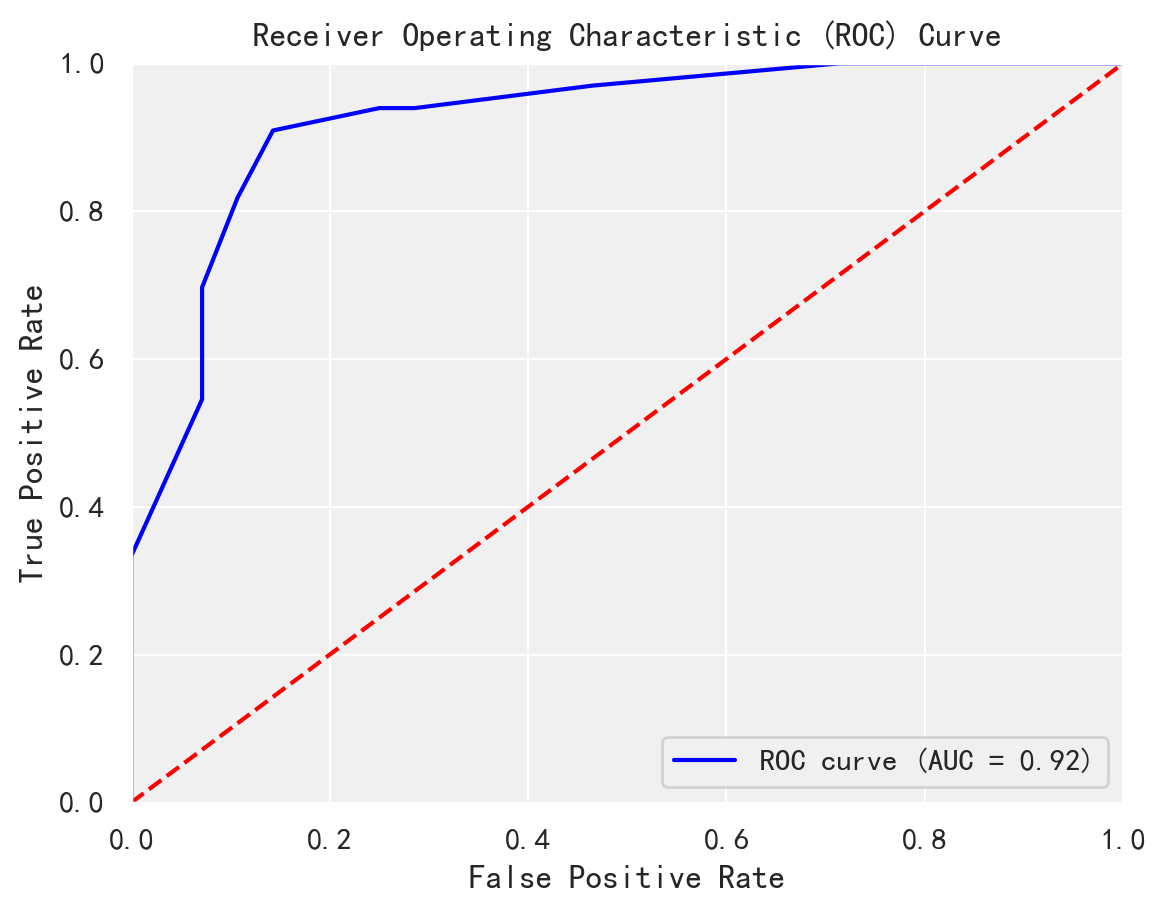

In [196]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 绘制随机猜测的参考线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(color='white', linestyle='-', linewidth=0.7)  # 设置白色网格
plt.show()

In [197]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       110
           1       0.85      0.88      0.87       132

    accuracy                           0.85       242
   macro avg       0.85      0.85      0.85       242
weighted avg       0.85      0.85      0.85       242



In [198]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        28
           1       0.88      0.91      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



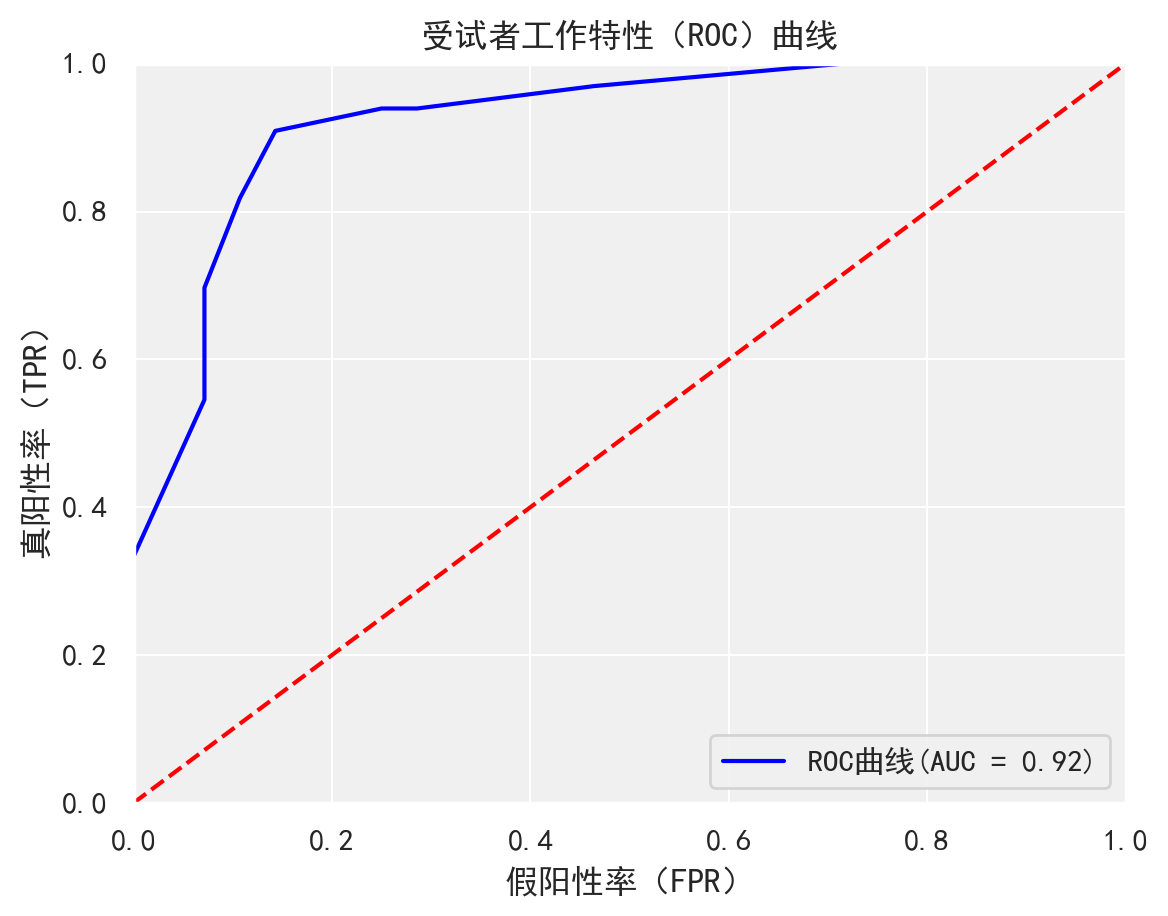

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy,auc
KNN,0.89,0.88,0.86,0.91,0.87,0.9,0.89,0.88,0.88,0.89,0.92


In [199]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

### 6.2 逻辑回归

#### 6.2.1 数据准备

##### **logistic算法**：
* 需要标准化：
  * 逻辑回归模型的参数（权重）是通过最大化似然函数来估计的。在梯度下降优化过程中，特征的尺度差异会影响参数更新的速度。如果特征的尺度差异很大，某些特征可能会主导模型训练过程，导致训练过程变得不稳定
  * L1 正则化（Lasso） 和 L2 正则化（Ridge） 都依赖于特征的尺度，标准化后，正则化项会作用于每个特征的相对重要性，而不是受特征尺度的影响。

In [200]:
try:
    mydf = Heart_Data_Process(df)
    mydf.Encode()
    #mydf.Box_Cox()
    mydf.Robust_Scaler()
    X_train = mydf.X_train
    X_test = mydf.X_test
    y_train = mydf.y_train
    y_test = mydf.y_test
except NameError:
    print("df未定义")



#### 6.2.2 调参

In [201]:
#logistics model
log_base = LogisticRegression()

In [202]:
# 定义参数分布
log_param_grid = {
    'C': uniform(0.01,100),  # 正则化强度的倒数
    'penalty': ['l1', 'l2', 'elasticnet'],  # 正则化类型
    'solver': ['liblinear']  # 优化算法
}

In [203]:
# 定义参数分布
log_param_grid = {
    'C': [0.01,0.1,1,10,100],  # 正则化强度的倒数
    'penalty': ['l1', 'l2', 'elasticnet'],  # 正则化类型
    'solver': ['liblinear'] # 优化算法
}

In [204]:
# Hyperparameter tuning for log
best_log, best_log_hyperparams = tune_clf_hyperparameters(log_base, log_param_grid, X_train, y_train,scoring = 'recall',method = 'Grid')
print('log Optimal Hyperparameters: \n', best_log_hyperparams)

log Optimal Hyperparameters: 
 {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [205]:
# 输出模型参数
# 系数
print('Coefficients:', best_log.coef_)
# 截距
print('Intercept:', best_log.intercept_)

Coefficients: [[ 0.         -0.47012667 -0.21320721 -0.06575381  0.08924384  0.39336832
  -1.16914653 -0.85961834  0.26912206 -0.66341638  0.46082971  1.86894941
   0.99431859  0.70787253  0.          0.6472304   1.07516661 -0.44843561]]
Intercept: [0.]


In [206]:
# 获取系数和特征名称
coefficients = best_log.coef_[0]  # 对于二分类问题，coef_是一个二维数组，我们取第一个元素
feature_names = X_train.columns

# 创建一个DataFrame，将系数和特征名称结合起来
coef_df = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])

# 打印模型形式
print("Model Form:")
print("ln(P(Y=1)/P(Y=0)) =", best_log.intercept_[0], "+", sep="")

# 使用列表推导式和join方法打印特征和系数
print("+".join([f" {coef:.2f}*{name}" if coef >= 0 else f"( -{abs(coef):.2f})*{name}" for coef, name in zip(coef_df['Coefficient'], coef_df.index)]))

Model Form:
ln(P(Y=1)/P(Y=0)) =0.0+
 0.00*age+( -0.47)*sex+( -0.21)*trestbps+( -0.07)*chol+ 0.09*fbs+ 0.39*thalach+( -1.17)*exang+( -0.86)*oldpeak+ 0.27*slope+( -0.66)*ca+ 0.46*cp_1+ 1.87*cp_2+ 0.99*cp_3+ 0.71*restecg_1+ 0.00*restecg_2+ 0.65*thal_1+ 1.08*thal_2+( -0.45)*thal_3


### 6.2.3 模型评价

In [207]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_log.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       110
           1       0.82      0.89      0.85       132

    accuracy                           0.83       242
   macro avg       0.84      0.83      0.83       242
weighted avg       0.84      0.83      0.83       242



In [208]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_log.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



[[22  6]
 [ 4 29]]


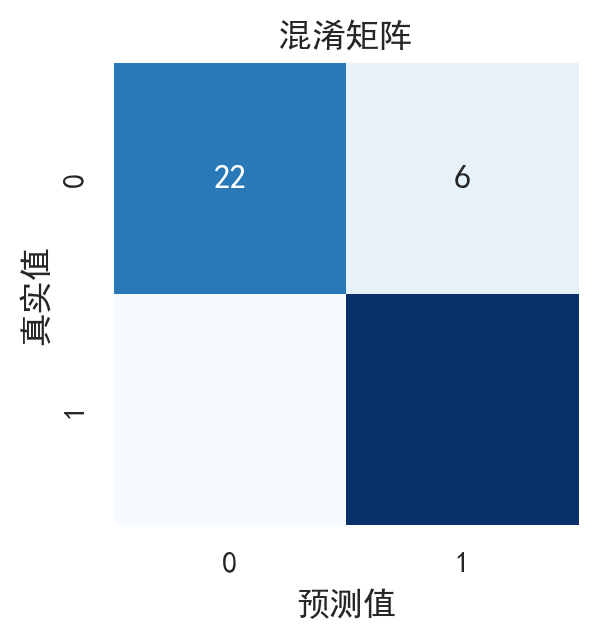

In [209]:
# confusion_matrix
cm = confusion_matrix(y_test, best_log.predict(X_test))
print(cm)
# 使用seaborn的heatmap函数来绘制混淆矩阵
plt.figure(figsize=(3,3))  # 设置图形的大小
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.title('混淆矩阵')
plt.show()

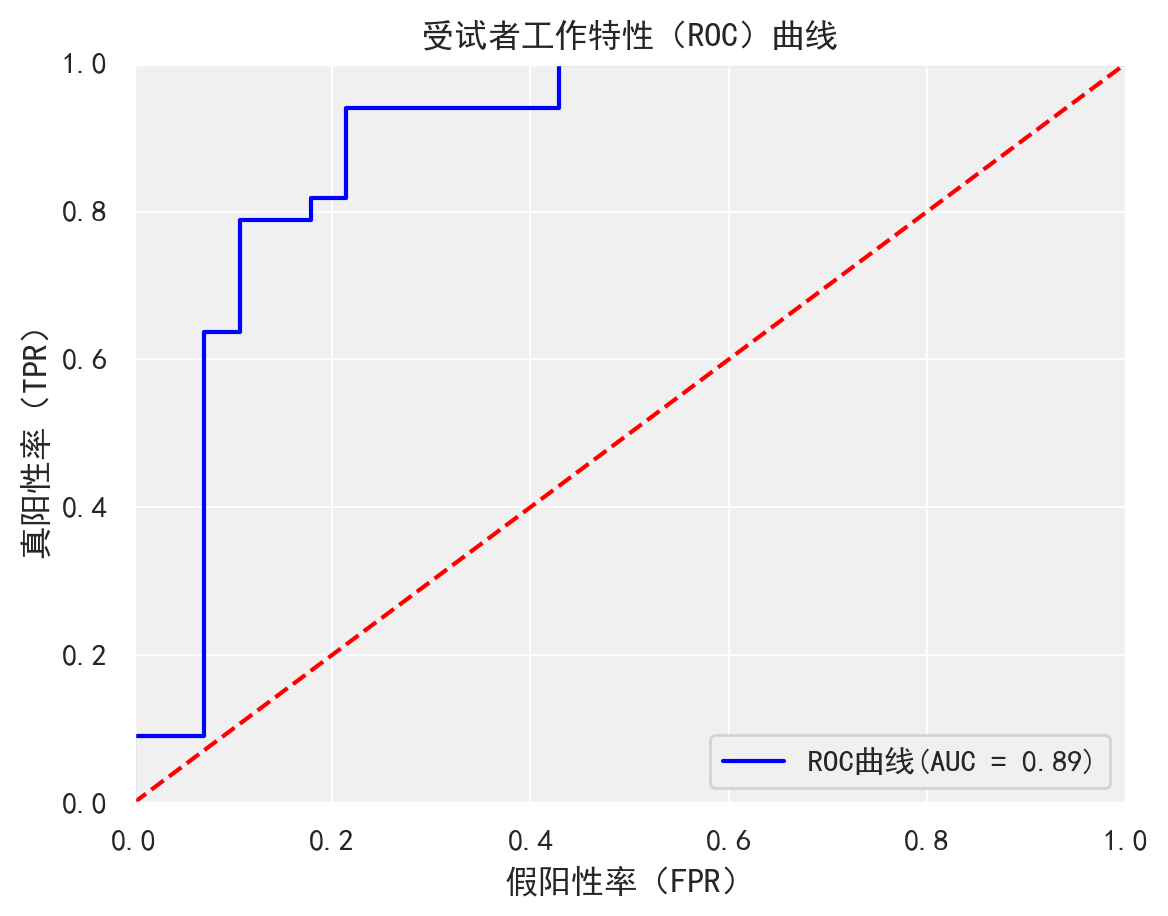

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy,auc
log,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84,0.89


In [210]:
log_evaluation = evaluate_model(best_log, X_test, y_test, 'log')
log_evaluation

### 6.3 XGBoost

#### 6.3.1 数据准备

In [211]:
try:
    mydf = Heart_Data_Process(df)
    mydf.Encode()
    mydf.Box_Cox()
    mydf.Robust_Scaler()
    X_train = mydf.X_train
    X_test = mydf.X_test
    y_train = mydf.y_train
    y_test = mydf.y_test
except NameError:
    print("df未定义")

### 6.3.2 调参

In [212]:
xgb_base = xgb.XGBClassifier()

In [213]:
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [1,3, 4, 5,7,9],
    'min_child_weight': [1, 3, 5,7,9],
    'reg_alpha': [0, 0.1, 0.5,0.7,0.9],
    'reg_lambda': [0.5,1,2],
    'colsample_bytree': [0.5,0.6,0.7,0.8, 0.9, 1.0],
    'subsample': [0.5,0.6,0.7,0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3,0.5]
}

In [214]:
xgb_param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1, 2]
}

In [215]:
# Hyperparameter tuning for log
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, xgb_param_grid, X_train, y_train,scoring = 'recall',method = 'Grid')
print('xgb Optimal Hyperparameters: \n', best_xgb_hyperparams)

xgb Optimal Hyperparameters: 
 {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


### 6.3.3 模型评价

In [216]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_xgb.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       110
           1       0.88      0.98      0.92       132

    accuracy                           0.91       242
   macro avg       0.92      0.91      0.91       242
weighted avg       0.92      0.91      0.91       242



In [217]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.78      0.88      0.83        33

    accuracy                           0.80        61
   macro avg       0.81      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



[[20  8]
 [ 4 29]]


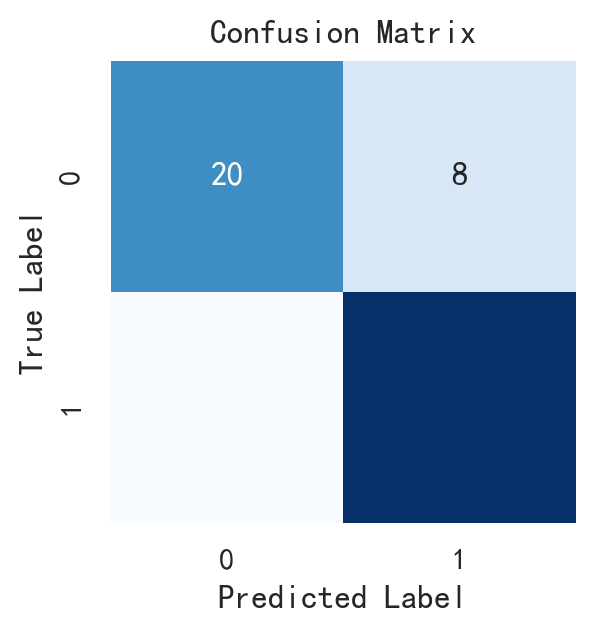

In [218]:
# confusion_matrix
cm = confusion_matrix(y_test, best_xgb.predict(X_test))
print(cm)
# 使用seaborn的heatmap函数来绘制混淆矩阵
plt.figure(figsize=(3,3))  # 设置图形的大小
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

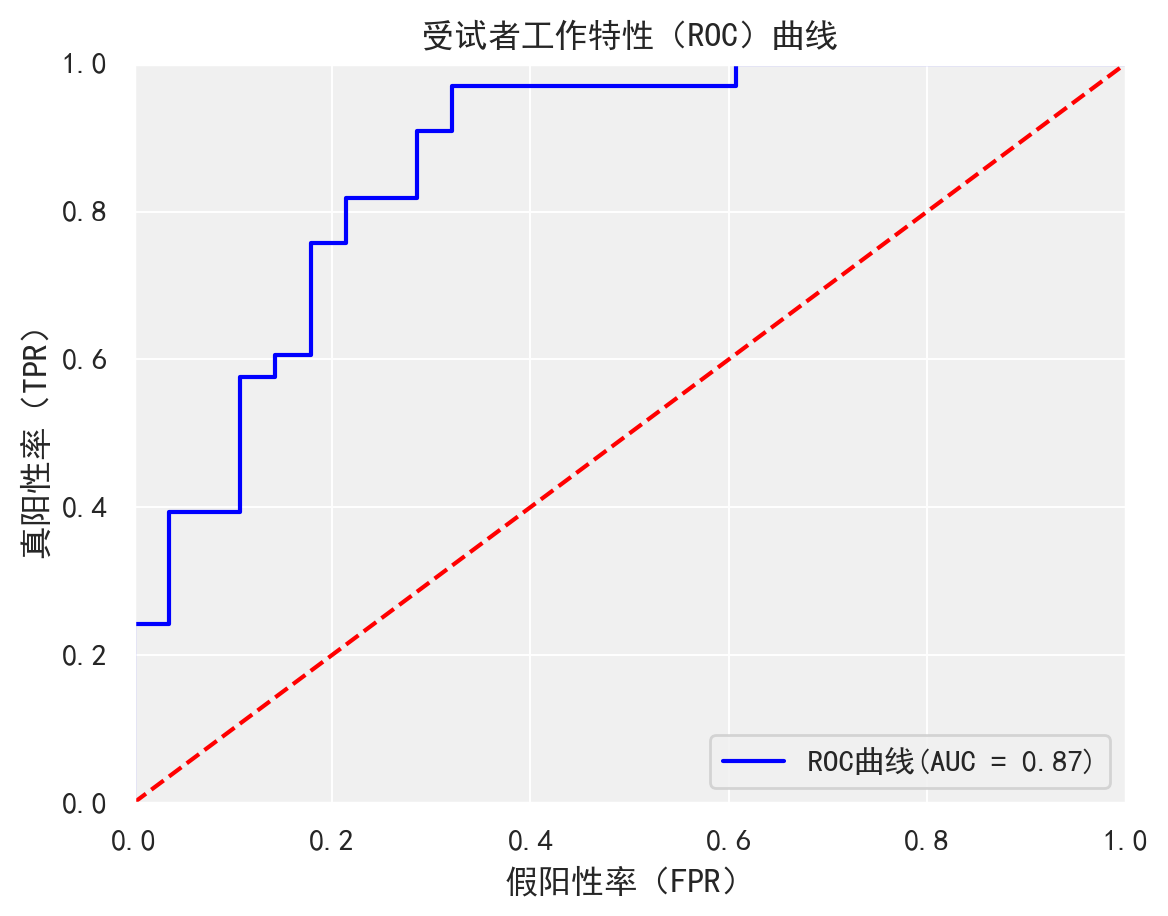

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy,auc
xgb,0.83,0.78,0.71,0.88,0.77,0.83,0.81,0.8,0.8,0.8,0.87


In [219]:
xgb_evaluation = evaluate_model(best_xgb, X_test, y_test, 'xgb')
xgb_evaluation

## 7.模型比较

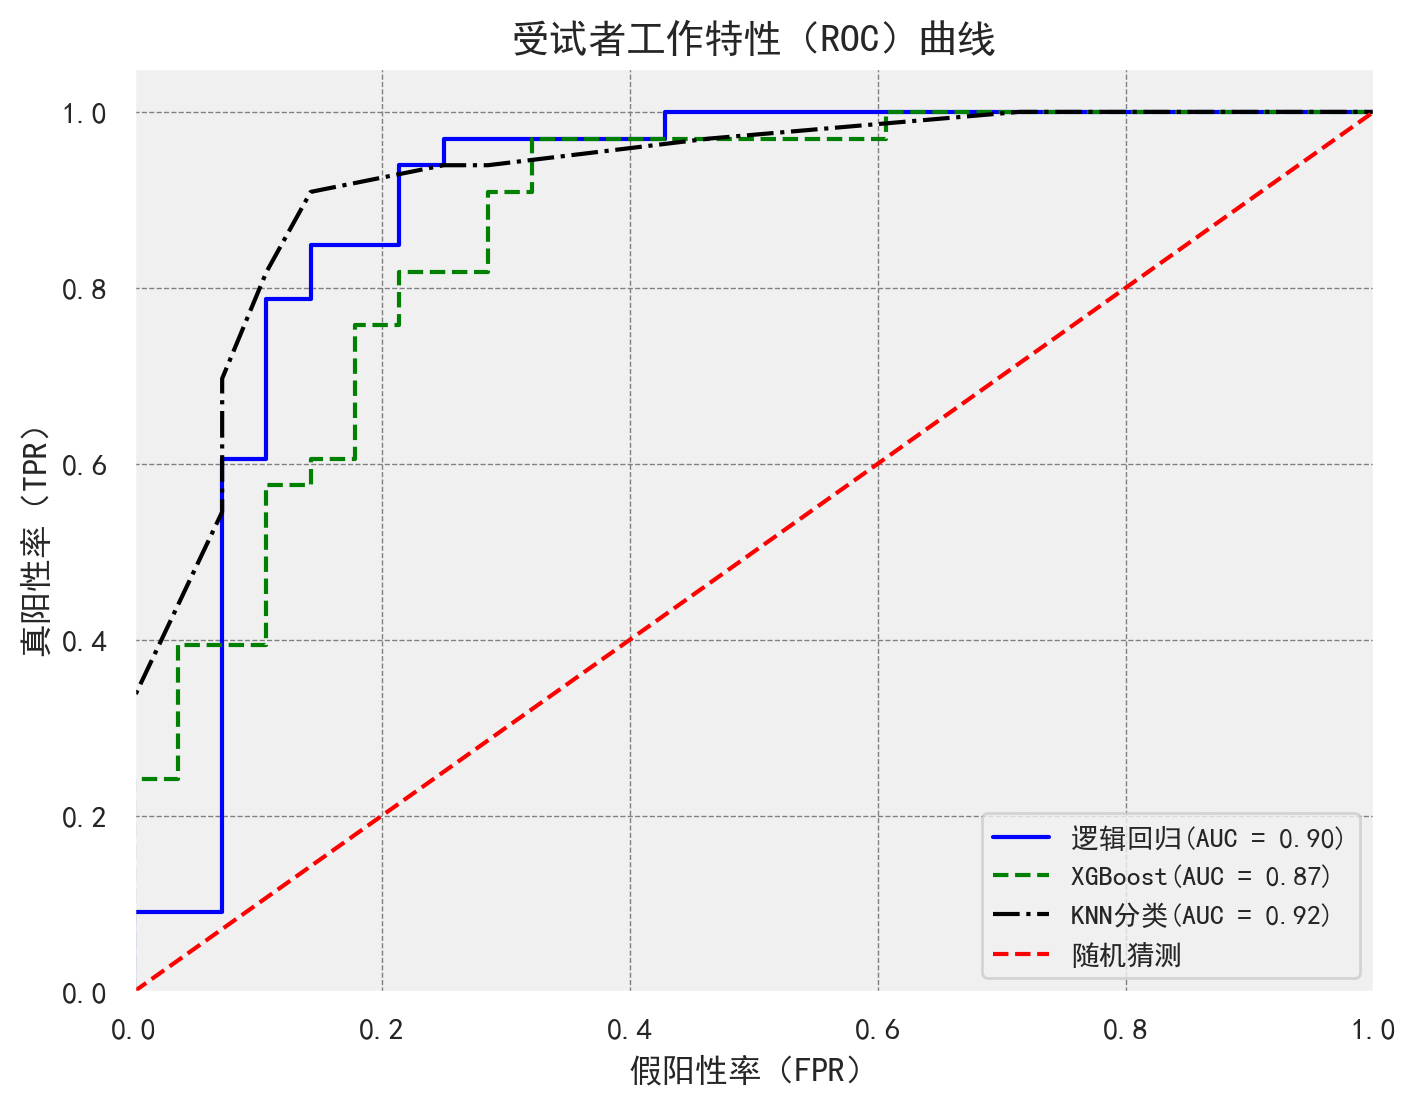

In [220]:
# 计算每个模型的FPR, TPR和阈值
fpr1, tpr1, thresholds1 = roc_curve(y_test, best_log.predict_proba(X_test)[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, best_knn.predict_proba(X_test)[:, 1])

# 计算AUC值
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.plot(fpr1, tpr1, color='blue', linestyle='-', label='逻辑回归(AUC = {:.2f})'.format(roc_auc1))
plt.plot(fpr2, tpr2, color='green', linestyle='--', label='XGBoost(AUC = {:.2f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='black', linestyle='-.', label='KNN分类(AUC = {:.2f})'.format(roc_auc3))

# 绘制随机猜测的参考线
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='随机猜测')

# 设置坐标轴范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])  # 稍微扩展Y轴范围以显示所有标签

# 设置坐标轴标签
plt.xlabel('假阳性率（FPR）', fontsize=12)
plt.ylabel('真阳性率（TPR）', fontsize=12)

# 设置标题
plt.title('受试者工作特性（ROC）曲线', fontsize=14)

# 显示图例
plt.legend(loc="lower right", fontsize=10)

# 显示网格
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # 设置灰色虚线网格

# 显示图形
plt.show()

In [221]:
# 使用concat函数合并DataFrame
merged_evaluation = pd.concat([xgb_evaluation, log_evaluation,knn_evaluation], axis=0)
merged_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy,auc
xgb,0.83,0.78,0.71,0.88,0.77,0.83,0.81,0.80,0.80,0.80,0.87
log,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84,0.89
KNN,0.89,0.88,0.86,0.91,0.87,0.90,0.89,0.88,0.88,0.89,0.92


**二分类模型仅需看1类的指标和整体指标accuracy、auc即可**